<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/91_alfa_range_and_Initial_Conditions_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬📉 Phase-Space Analysis of Gene Regulatory System — Updated Version

- **Goal**: Study phase-space dynamics, bifurcations, and solution sensitivity of a gene regulatory system modeled by a 2D ODE system:  
  $$
  \frac{dx}{dt} = \frac{K \cdot x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}, \quad
  \frac{dy}{dt} = \frac{K \cdot y^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}
  $$
  
- **Fixed Parameters**:  
  - $b = 1.0$  
  - $K = 1.0$ (fixed scalar multiplier)  

- **Initial Conditions**: Multiple initial points near $b$:  
  $$
  x_0, y_0 \approx b \times (1 - \epsilon), \quad \epsilon \in \{10^{-7}, 10^{-8}, 10^{-9}\}
  $$  
  to explore sensitivity and multiple solution trajectories.

- **Time Interval**:  
  $$
  t \in [0, t_{\text{end}}], \quad t_{\text{end}} = 0.05
  $$

- **Alpha Range** (logarithmic scale, narrowed):  
  $$
  \alpha \in \{10^{-9}, 10^{-10}, 10^{-11}, 10^{-12}, 10^{-13}, 10^{-14}\}
  $$

## ⚙️ Numerical Solvers Implemented
- ⚡ `RK45` — Explicit Runge-Kutta 4(5) adaptive  
- 🌐 `DOP853` — Dormand-Prince 8(5,3), high order  
- 🧱 `BDF` — Backward Differentiation Formula, stiff solver  
- 🧿 `Radau` — Implicit Runge-Kutta, A-stable  
- 🐢 `RK23` — Explicit Runge-Kutta 2(3), lower order  
- 🌀 `Symplectic` — Custom explicit Euler stepper (non-native symplectic)

## 📈 Visualization & Diagnostics
- ✔️ Phase portraits ($y(t)$ vs $x(t)$) for each solver and each $\alpha$, plotting multiple initial conditions on each graph.  
- ➡️ Flow direction shown by arrows (quiver) along trajectories — arrow size tuned for clarity without clutter.  
- 🔄 Different colors, line styles, markers used to distinguish initial conditions; initial conditions annotated directly on curves.  
- ⚠️ Numerical error counts and failures logged for each solver and $\alpha$.  
- 📊 Summary table of:  
  - Total computational time per solver  
  - Number of function evaluations (`nfev`) — total calls to RHS function during integration.  

## 🧪 Advanced Numerical Analyses
- 🔍 **Lyapunov Exponent Estimation**:  
  Computed by measuring divergence of nearby trajectories, yielding an approximate largest Lyapunov exponent $\lambda$.  
  Positive $\lambda$ indicates chaotic or sensitive dynamics.  
- 🌪️ **Neimark–Sacker Bifurcation Detection**:  
  - Via Poincaré map approximated by solution at $t_{\text{end}}$  
  - Jacobian estimated by finite differences of perturbed initial states  
  - Eigenvalues examined for crossing outside the unit circle, signaling bifurcation.

## 📌 Implementation Notes
- Initial conditions perturbed near $b$ to probe multiple potential solutions or sensitivity.  
- Overflow control implemented by clipping exponents in logarithmic domain before exponentiation to prevent `NaN`/`Inf` issues.  
- `Symplectic` solver is a simple explicit Euler scheme serving as a phase-space baseline, as no native symplectic solver available in SciPy.  
- Failed integrations and error counts tracked per $\alpha$ and solver, with visualization of failure frequency vs $\log_{10}(\alpha)$ to localize problematic parameter regions.

---

*This notebook provides a framework for exploring complex dynamics in gene regulatory ODE systems, focusing on numerical stability, bifurcation analysis, and chaos detection using multiple solvers and parameter sweeps.*

In [37]:
# Modified code for a gene regulatory system with phase space visualization
# exploring stability and bifurcation in gene regulation ODE system

# Cell 1: Parameters and library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle
import time
from matplotlib import cm
from numpy.linalg import eigvals

b = 1.0
#t_end = 0.05
t_end = 1
K = 1.0
# alpha_list = [1e-4 * (10 ** -i) for i in range(10)]  # 1e-4 to 1e-13
alpha_list = [1e-9 * (10 ** -i) for i in range(6)]  # 1e-9 to 1e-14
#alpha_list = [1e-9 * (10 ** -i) for i in range(9)]  # 1e-9 to 1e-17

N = 500
t_eval = np.linspace(0, t_end, N)
initial_shifts = [-1e-3, -1e-6, 0.0, 1e-6, 1e-3]

print("Alpha values:", alpha_list)

MAX_LOG_MESSAGES = 3
all_methods = ["RK45", "DOP853", "BDF", "Radau", "RK23", "Symplectic"]
error_counts = {m: 0 for m in all_methods}
error_counts.update({m + '_msgs': 0 for m in all_methods})
fail_counts = {m: 0 for m in all_methods}
alpha_failed = {m: [] for m in all_methods}
style_map = {}

# Assign visual styles
for idx, shift in enumerate(initial_shifts):
    style_map[shift] = {
        "color": plt.cm.viridis(idx / len(initial_shifts)),
        "marker": ['o', 's', '^', 'v', 'D'][idx % 5],
        "linestyle": ['-', '--', ':', '-.', (0, (3, 1, 1, 1))][idx % 5]
    }

Alpha values: [1e-09, 1.0000000000000002e-10, 1.0000000000000001e-11, 1.0000000000000002e-12, 1.0000000000000002e-13, 1.0000000000000002e-14, 1e-15, 1e-16, 1e-17]


In [38]:
# Cell 2: Define system of ODEs

def get_rhs_system(alpha, method_name, error_log, K):
    error_log.setdefault(method_name + '_msgs', 0)

    def rhs(t, xy):
        x_safe = np.clip(xy[0], 1e-20, 1e20)
        y_safe = np.clip(xy[1], 1e-20, 1e20)
        inv_alpha = 1 / alpha
        try:
            log_x = np.log(x_safe)
            log_y = np.log(y_safe)
            log_b = np.log(b)
            exp_x = np.exp(np.clip(log_x * inv_alpha, -700, 700))
            exp_y = np.exp(np.clip(log_y * inv_alpha, -700, 700))
            exp_b = np.exp(np.clip(log_b * inv_alpha, -700, 700))
            denom = exp_b + exp_x
            dxdt = K * exp_x / denom
            dydt = K * exp_y / denom
            return [dxdt, dydt]
        except Exception as e:
            error_log[method_name] += 1
            if error_log[method_name + '_msgs'] < MAX_LOG_MESSAGES:
                print(f"Numerical error in {method_name} at t={t:.5f}, x={x_safe:.5f}, y={y_safe:.5f}, alpha={alpha:.2e}: {e}")
                error_log[method_name + '_msgs'] += 1
            return [0.0, 0.0]

    return rhs

Solving with method: RK45


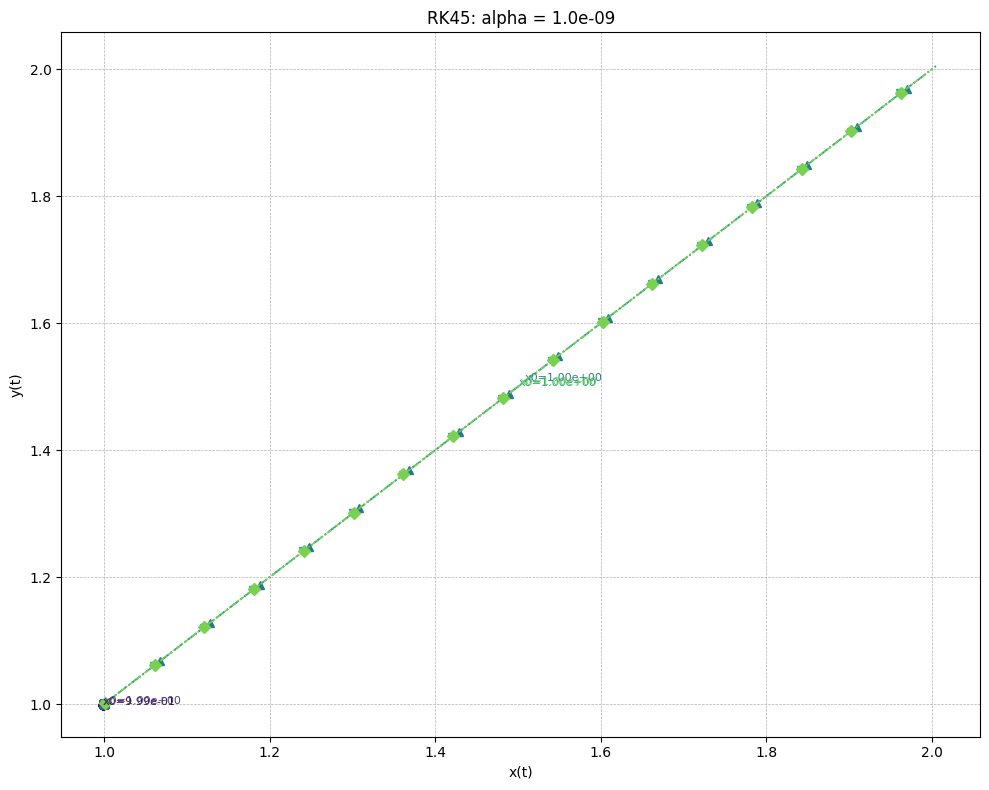

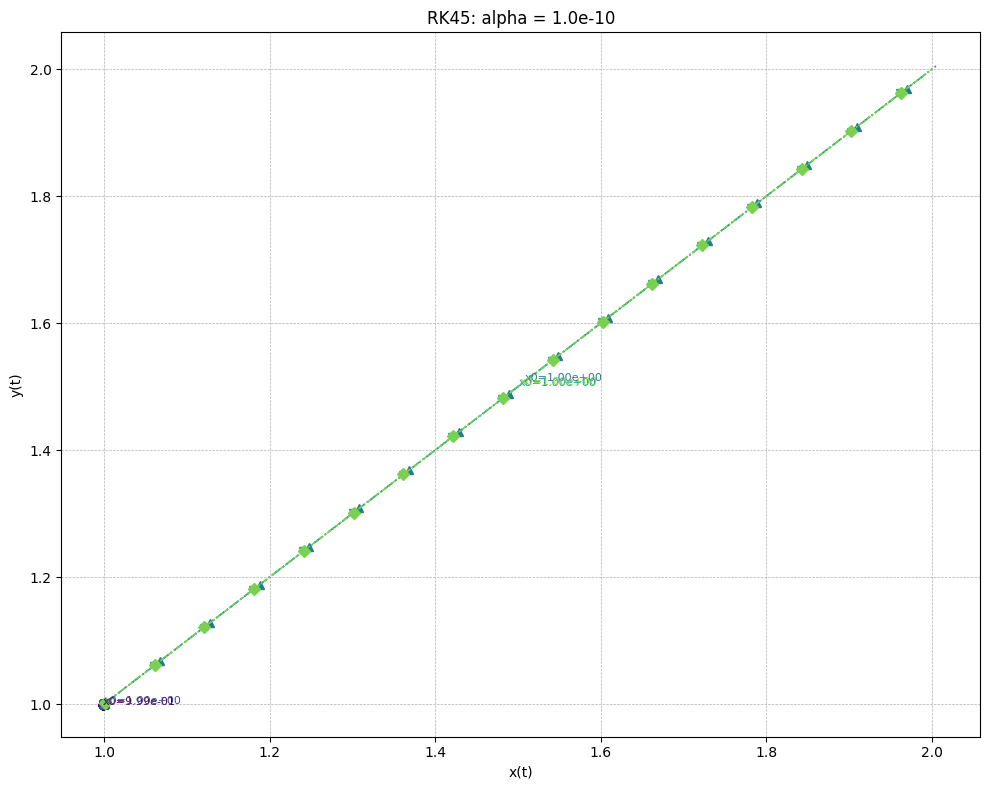

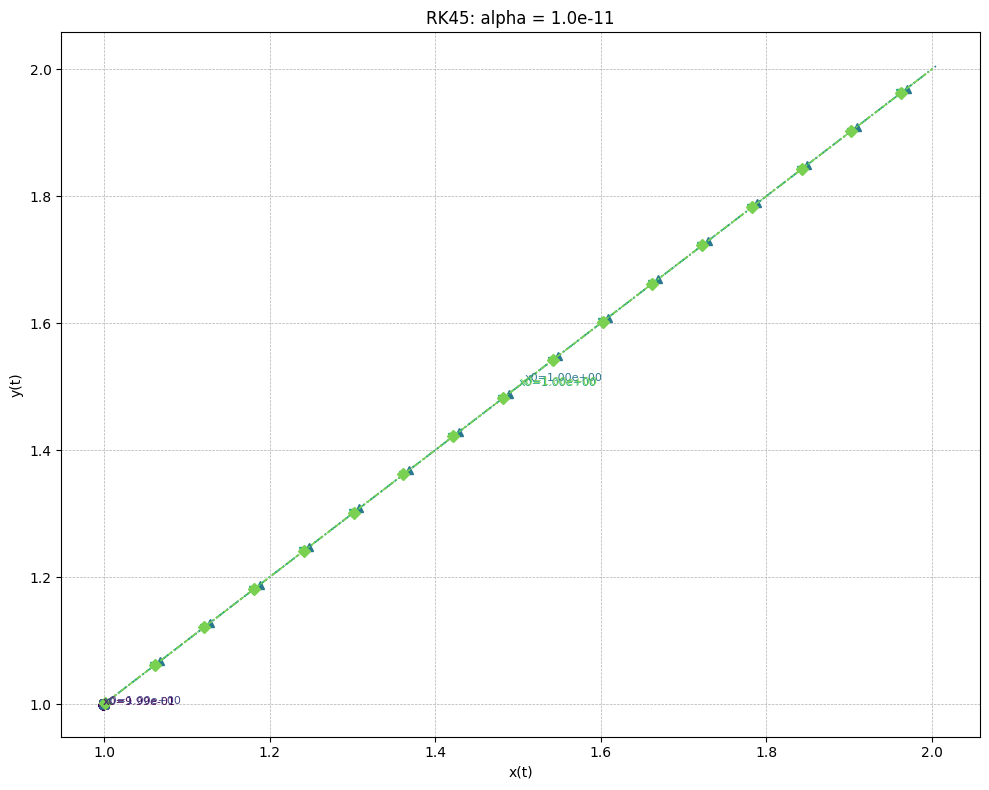

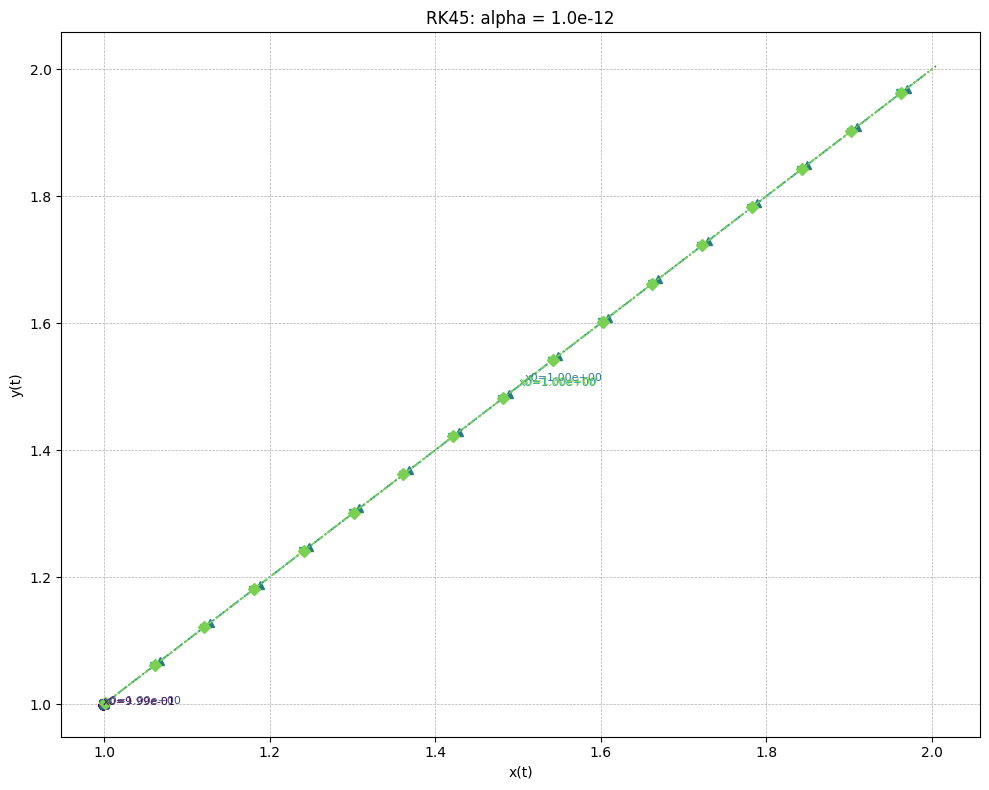

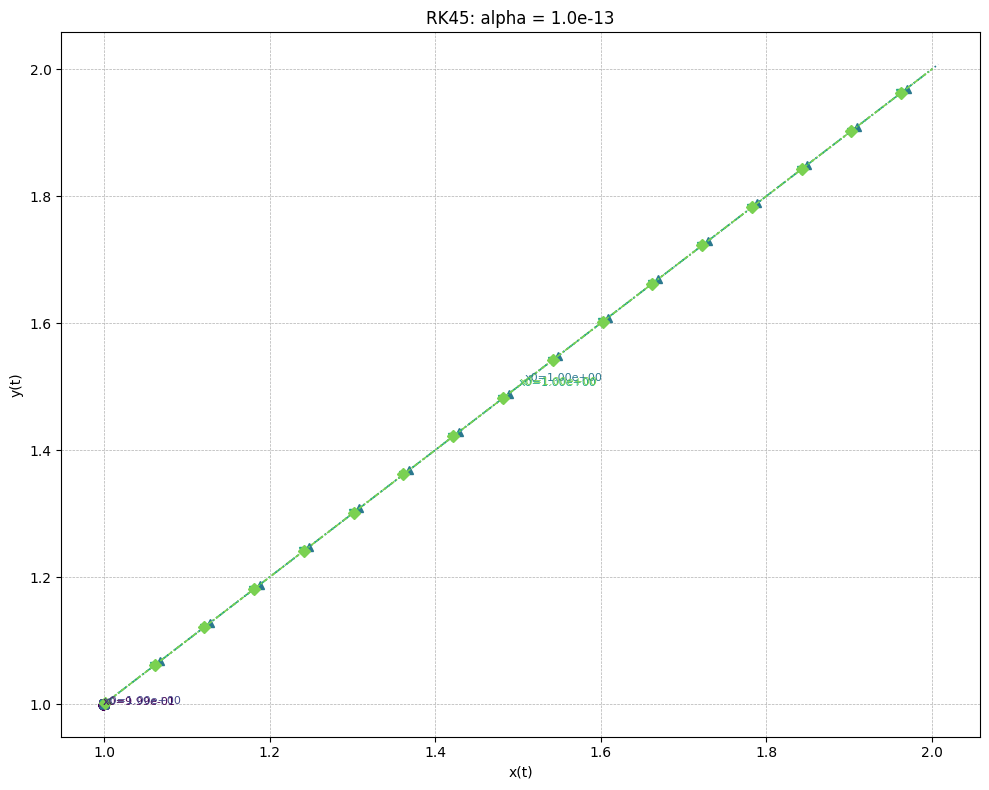

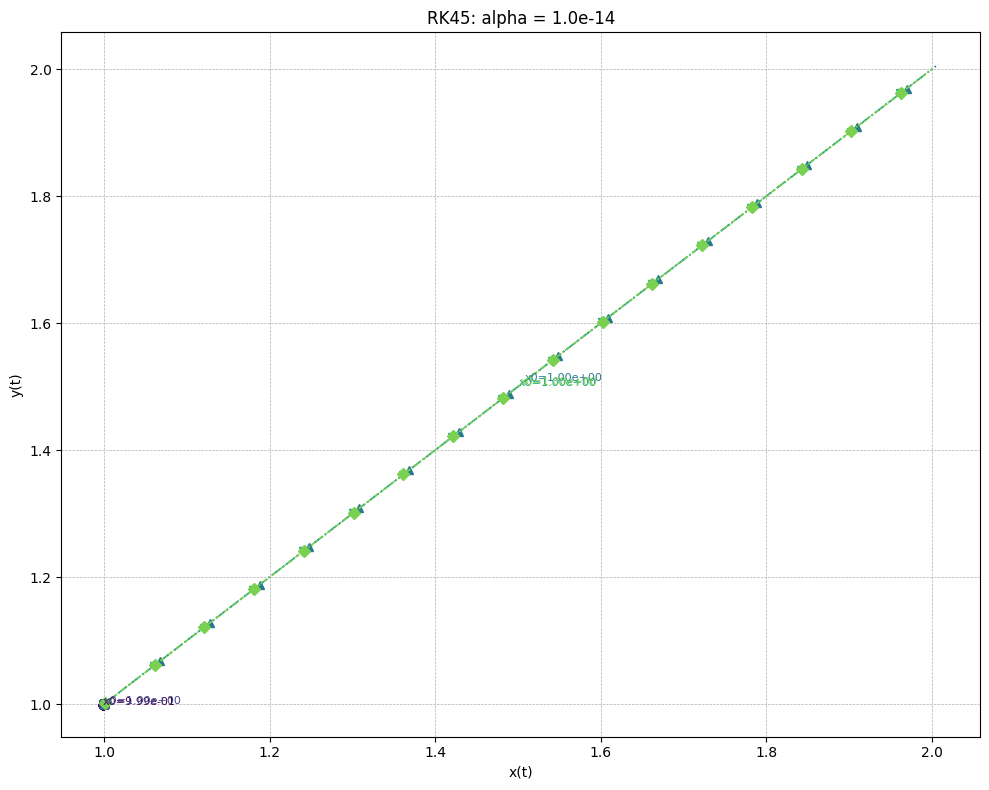

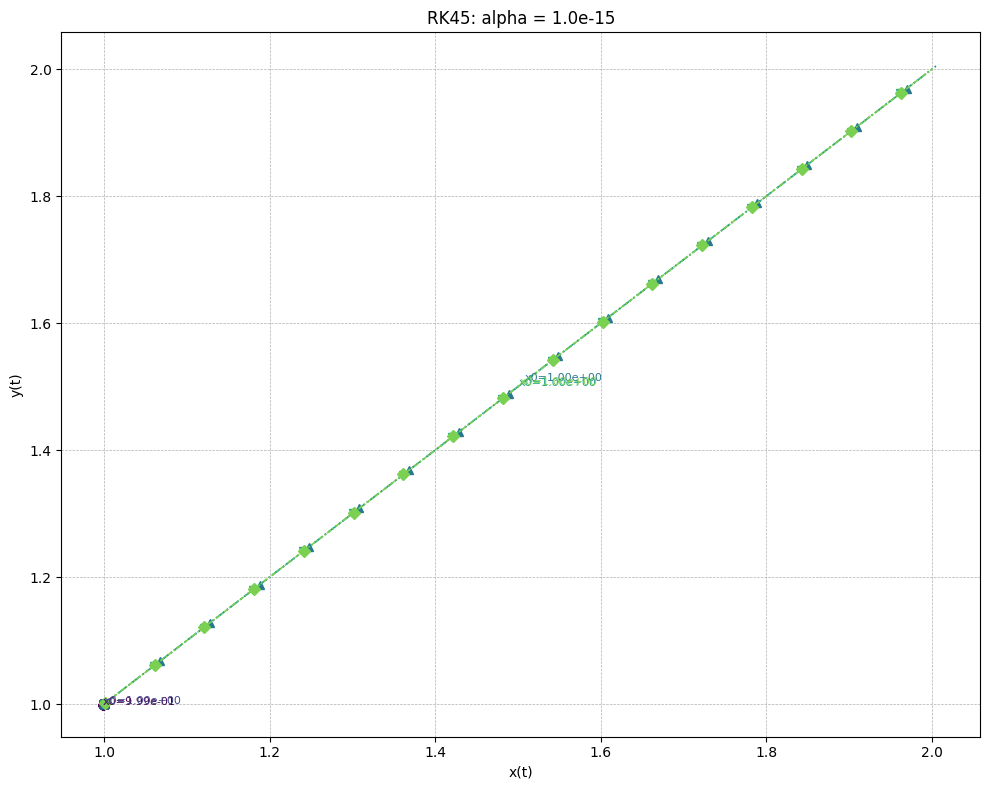

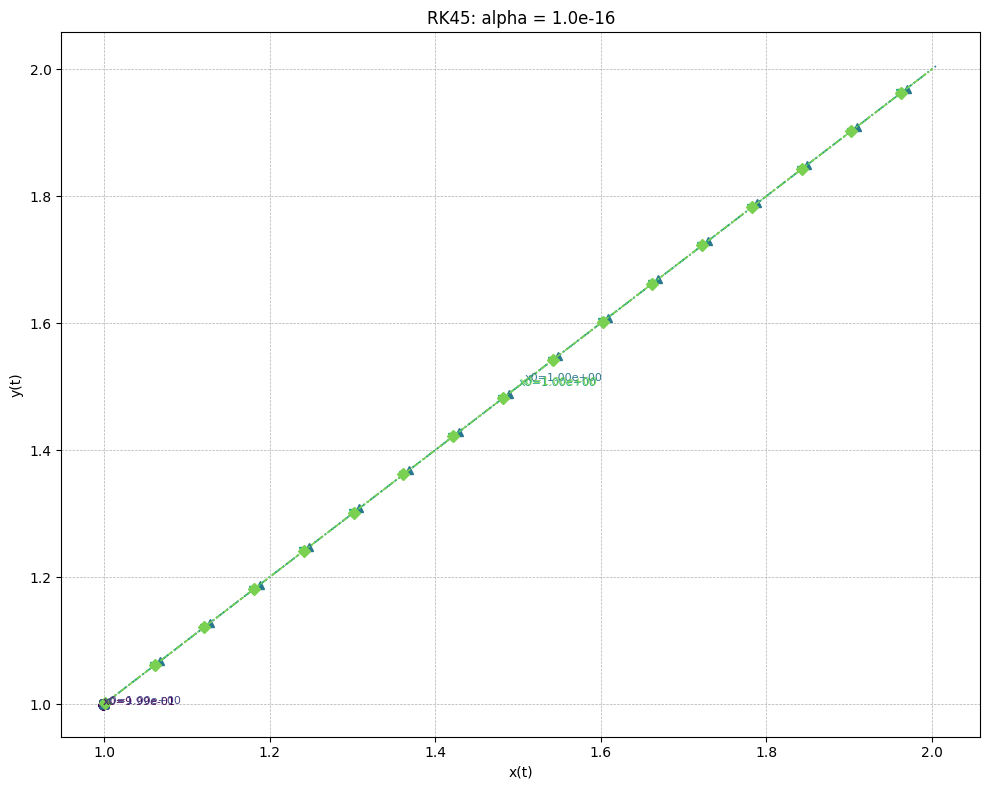

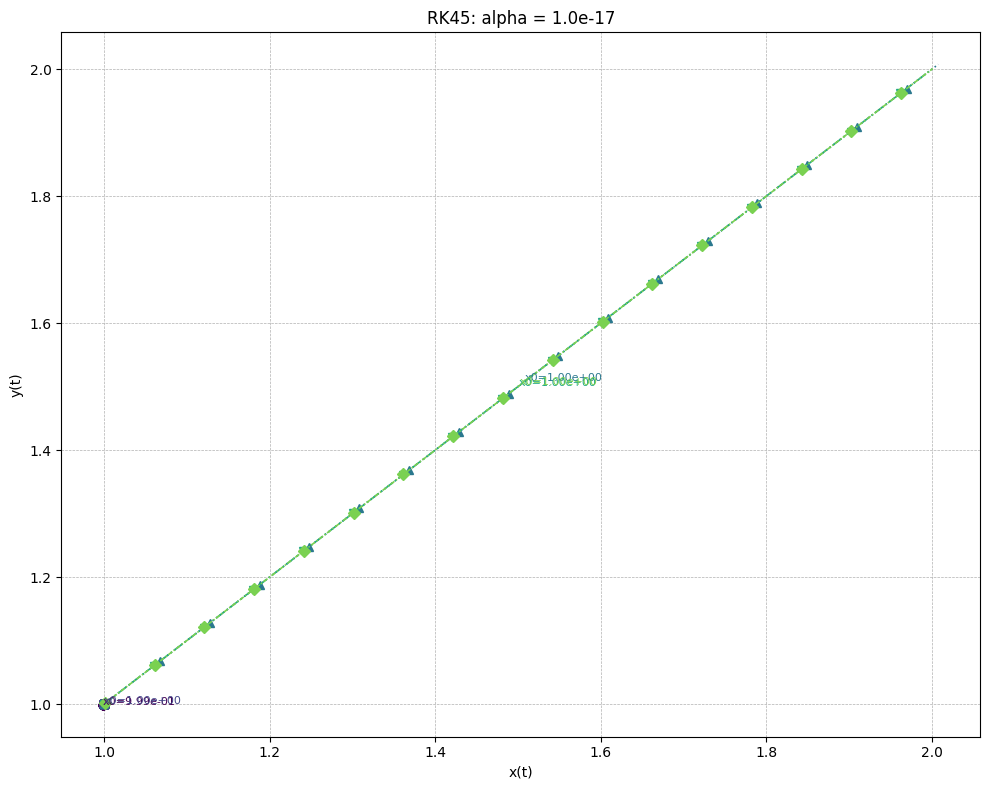

Solving with method: DOP853


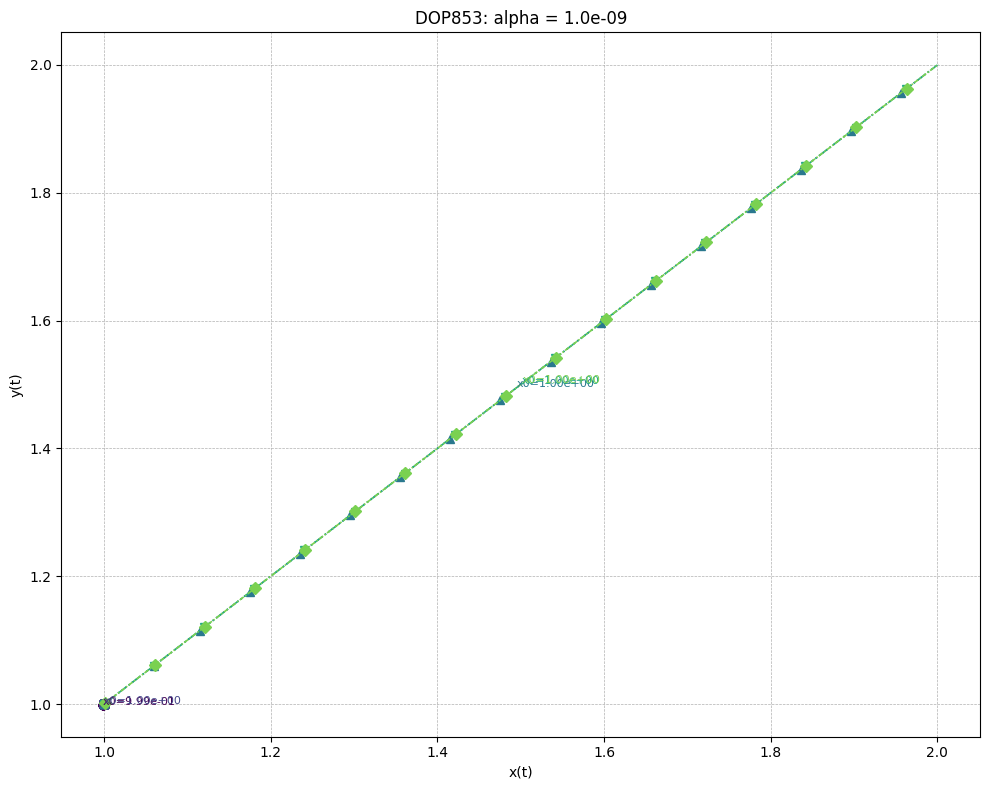

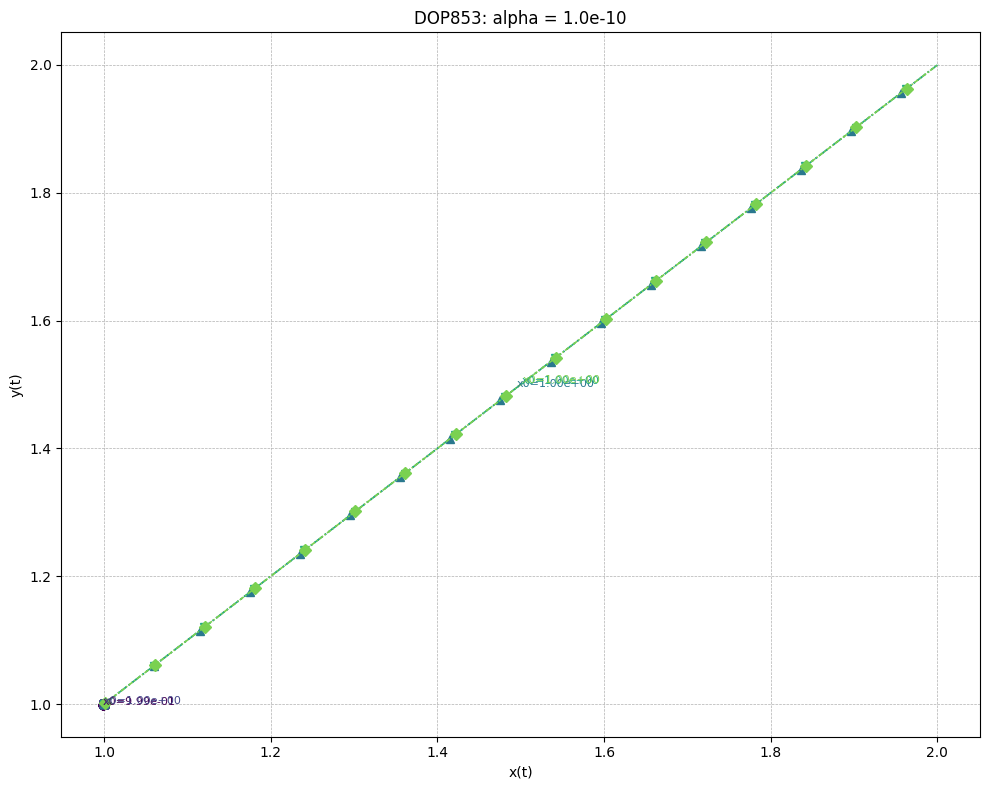

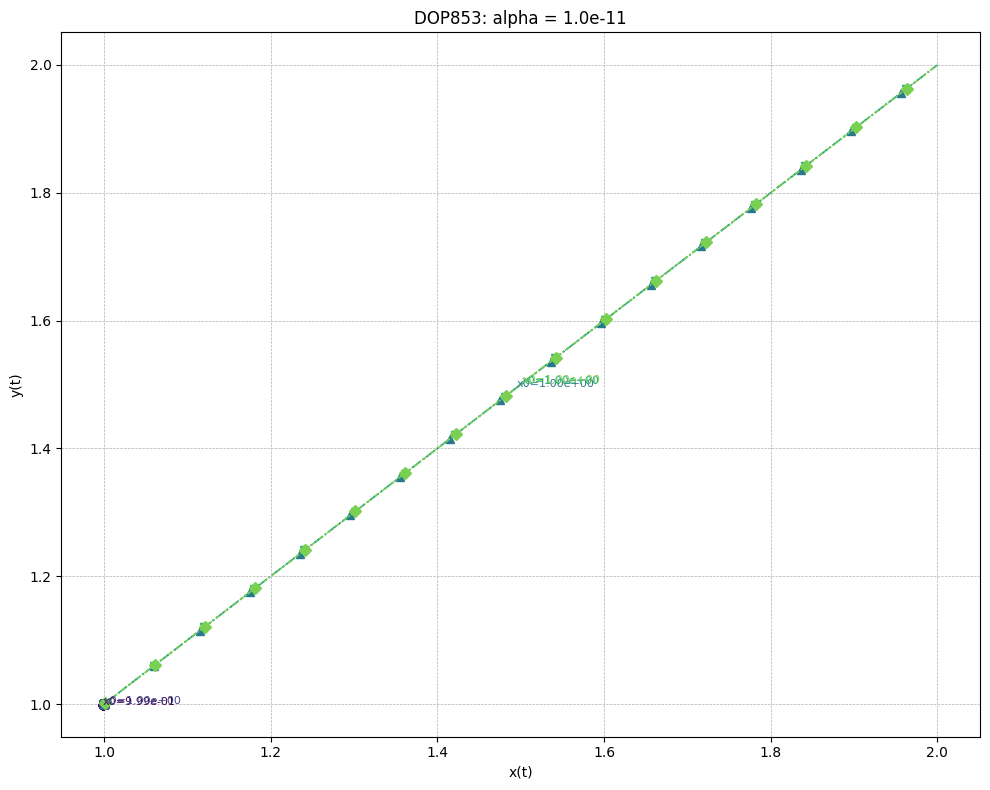

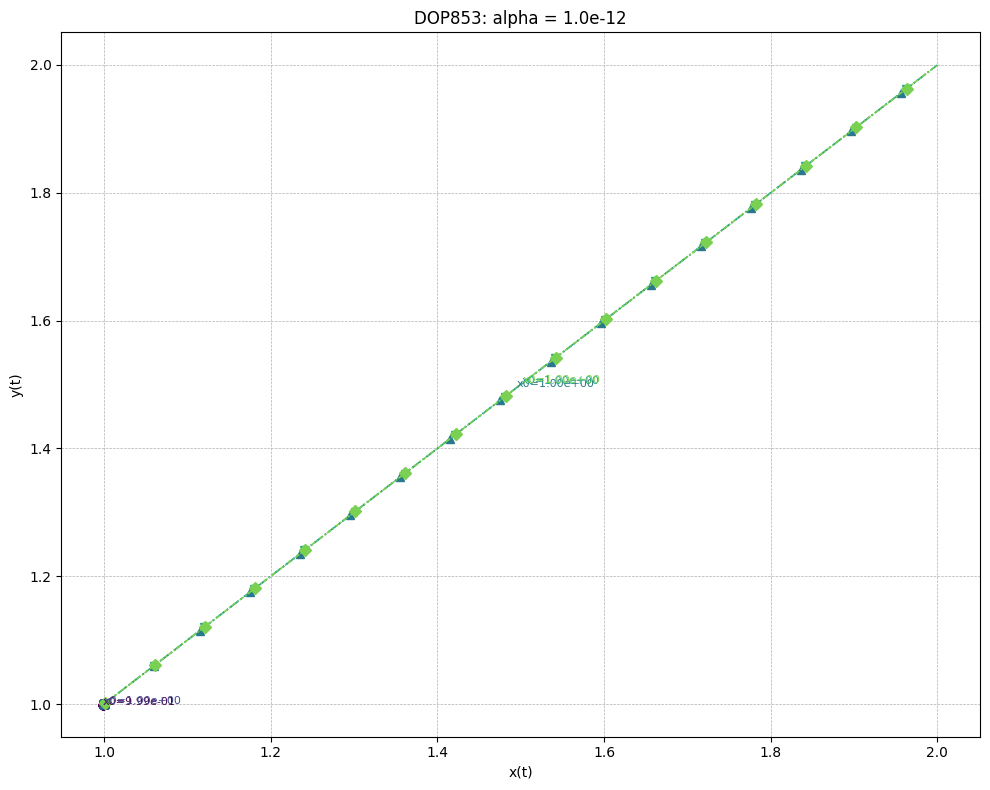

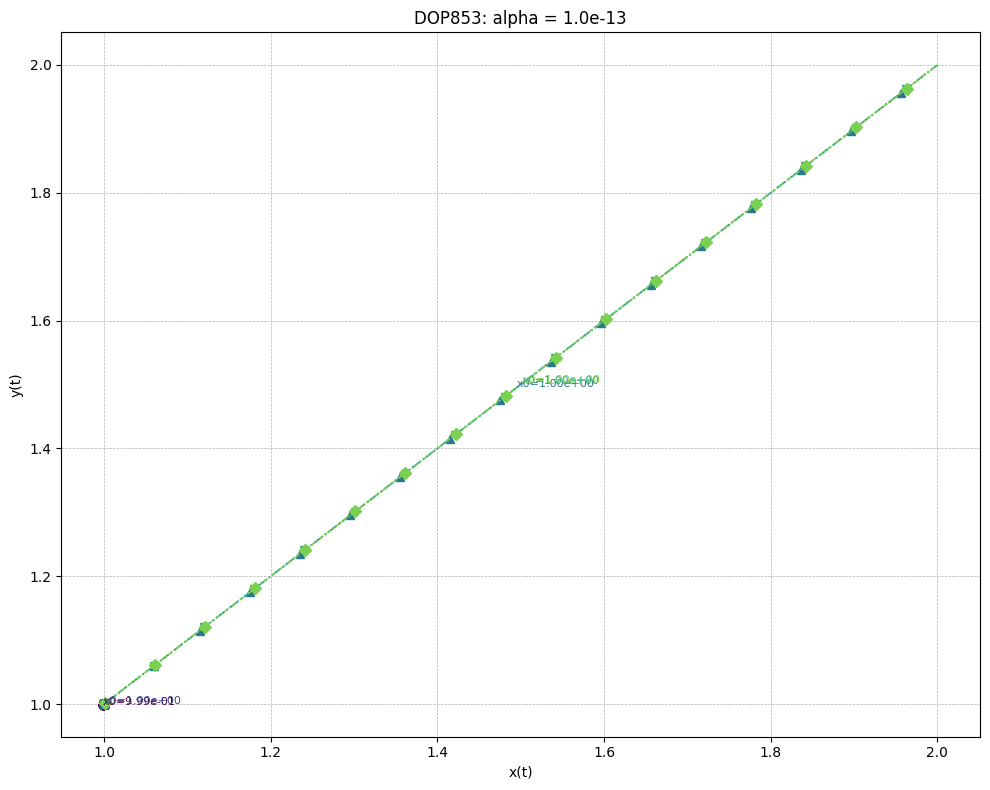

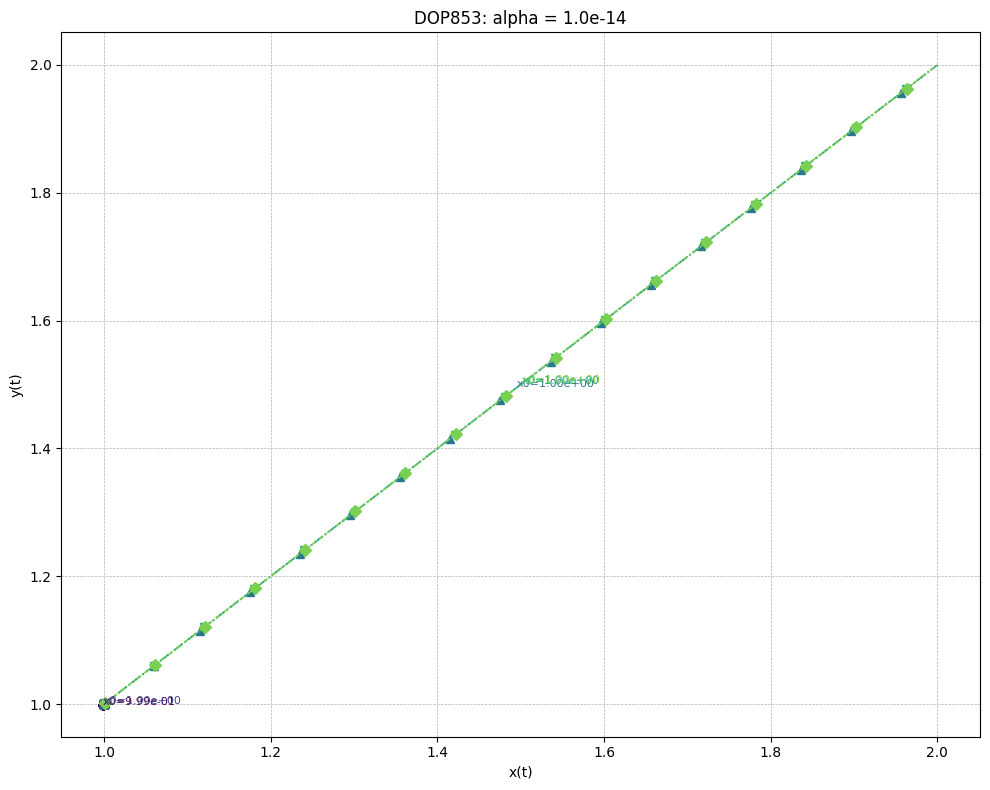

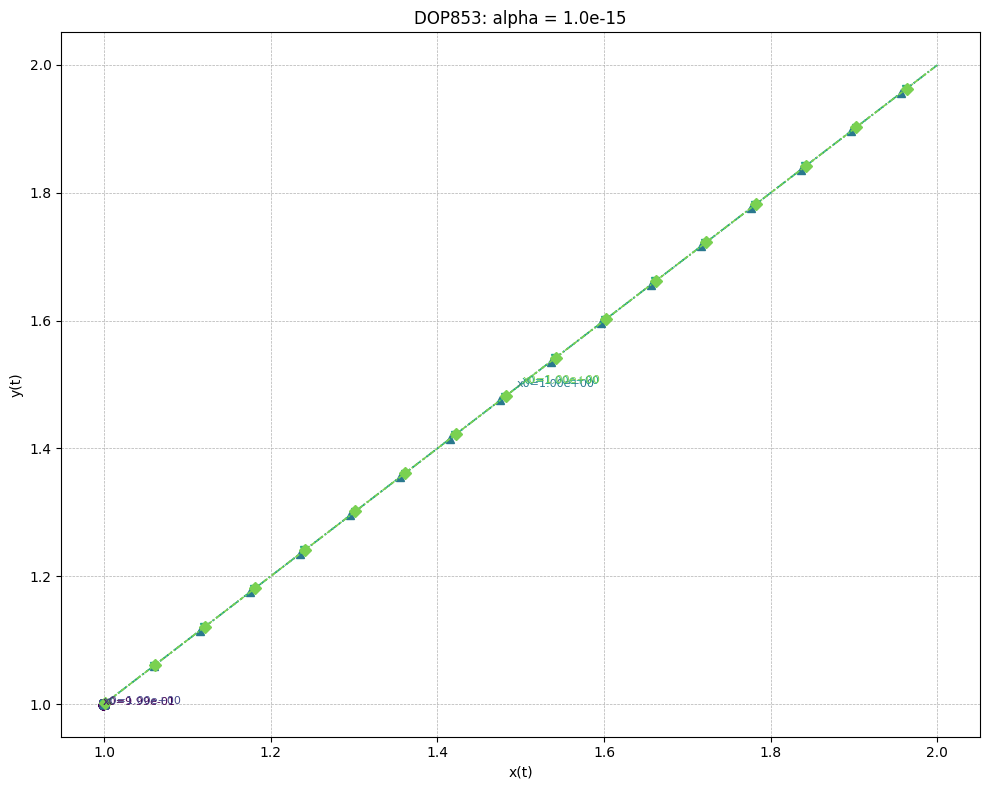

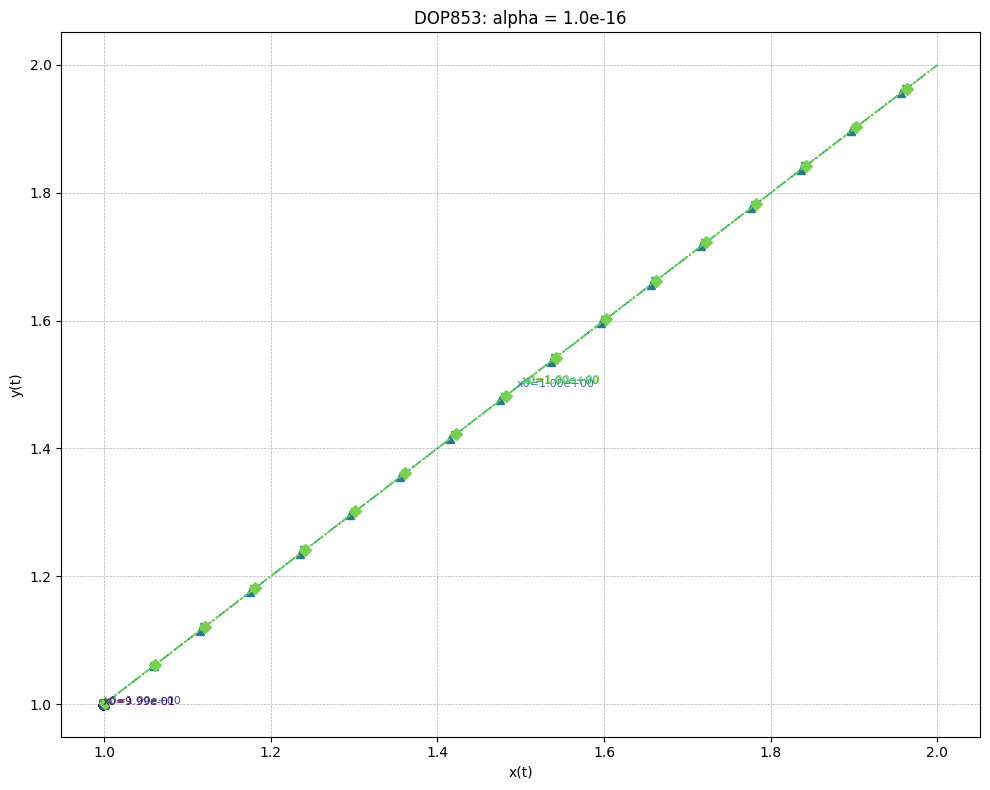

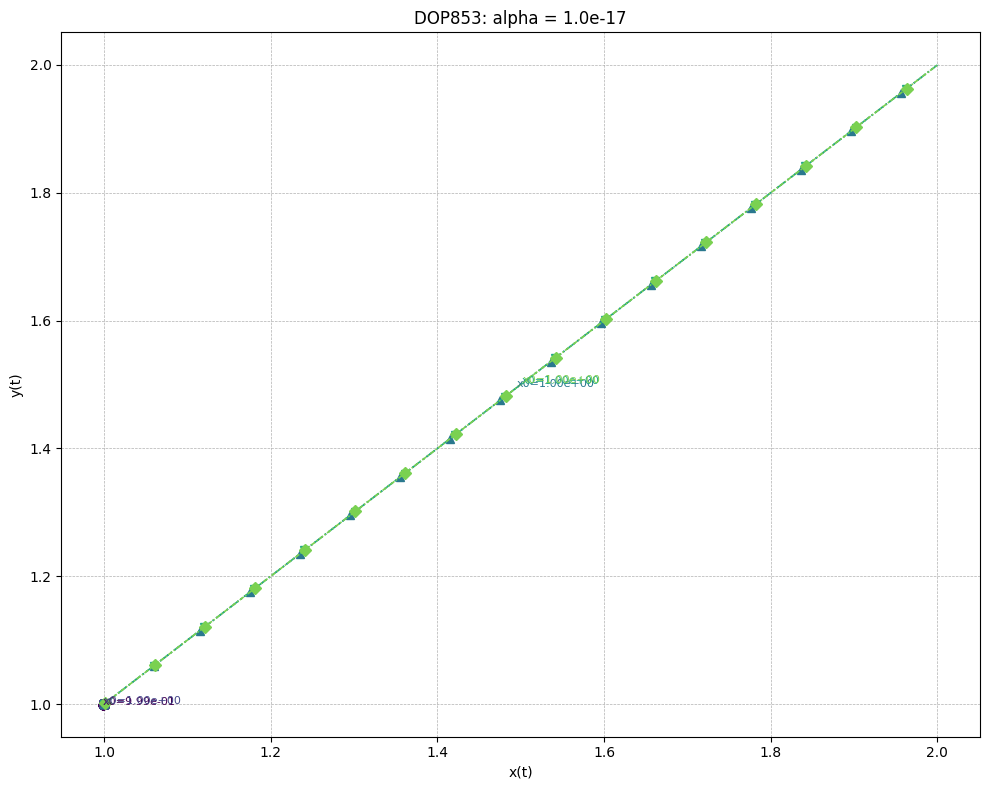

Solving with method: BDF


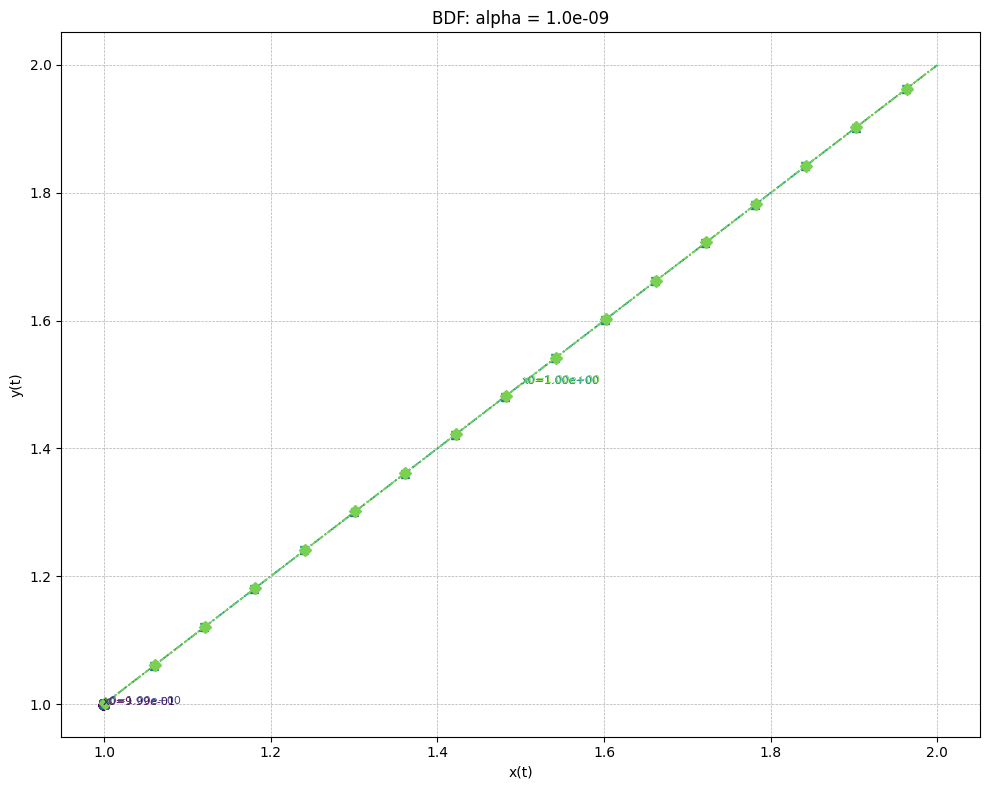

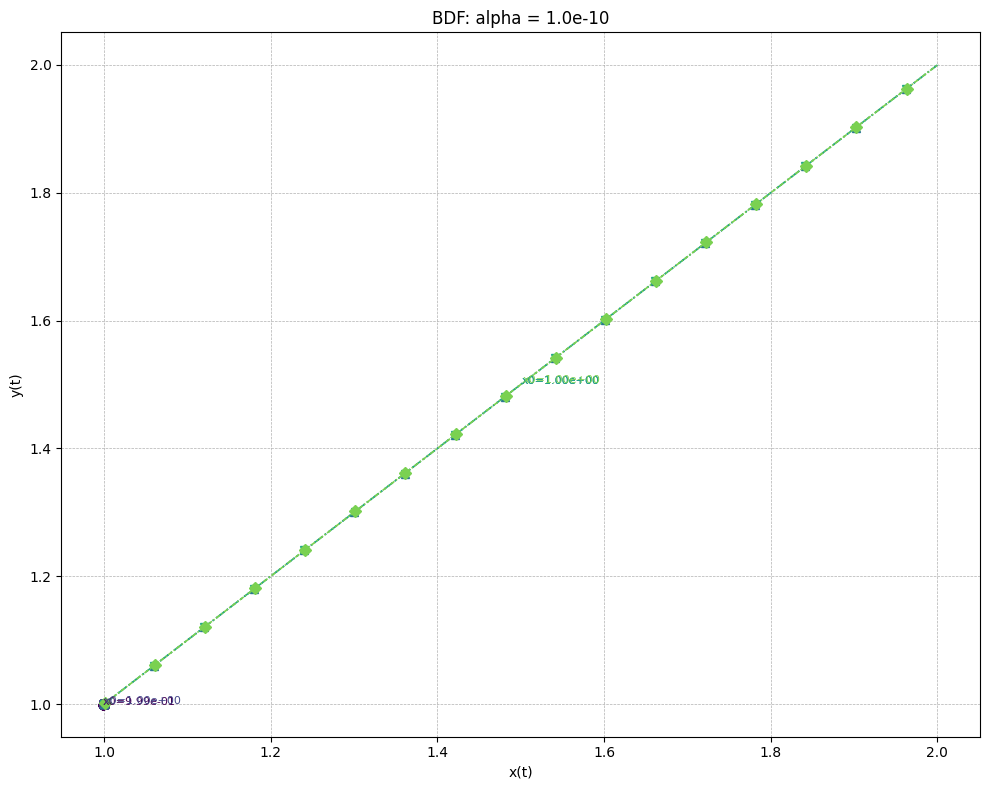

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/common.py:376: RuntimeWarning: overflow encountered in divide
  diff /= h


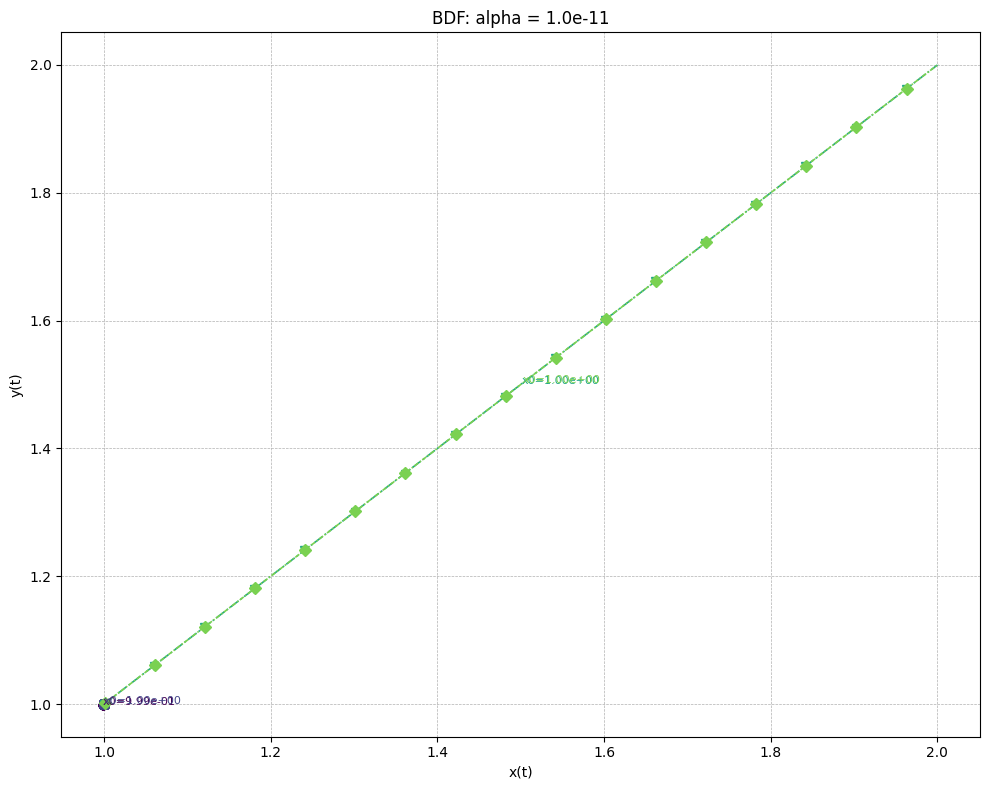

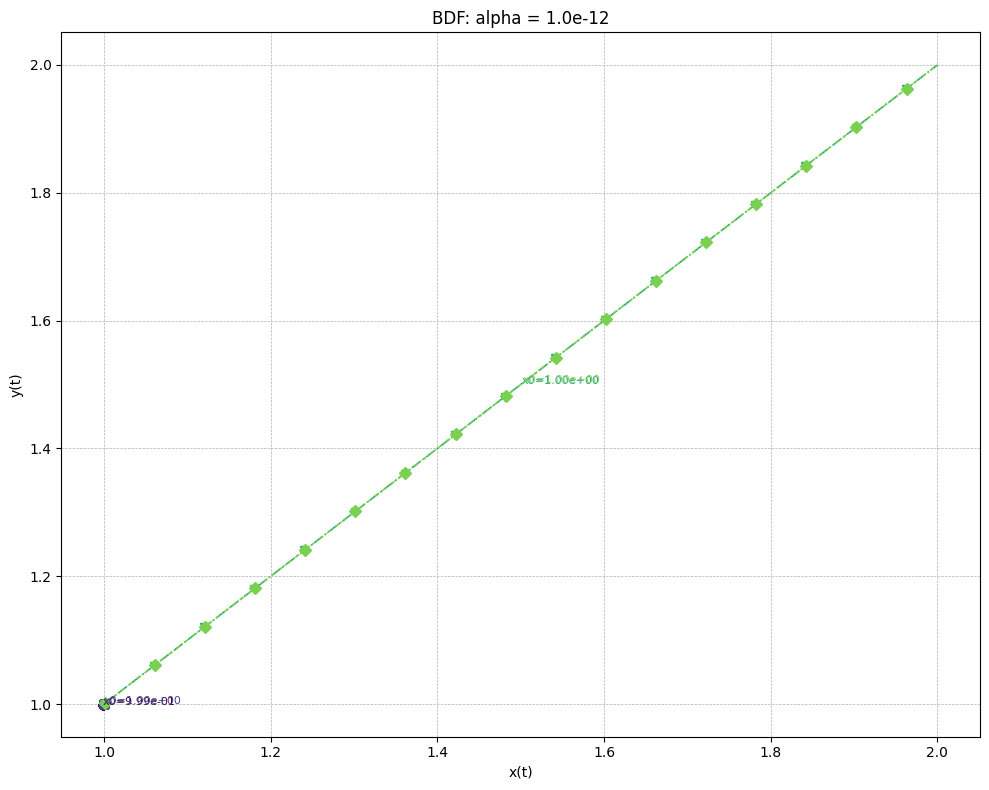

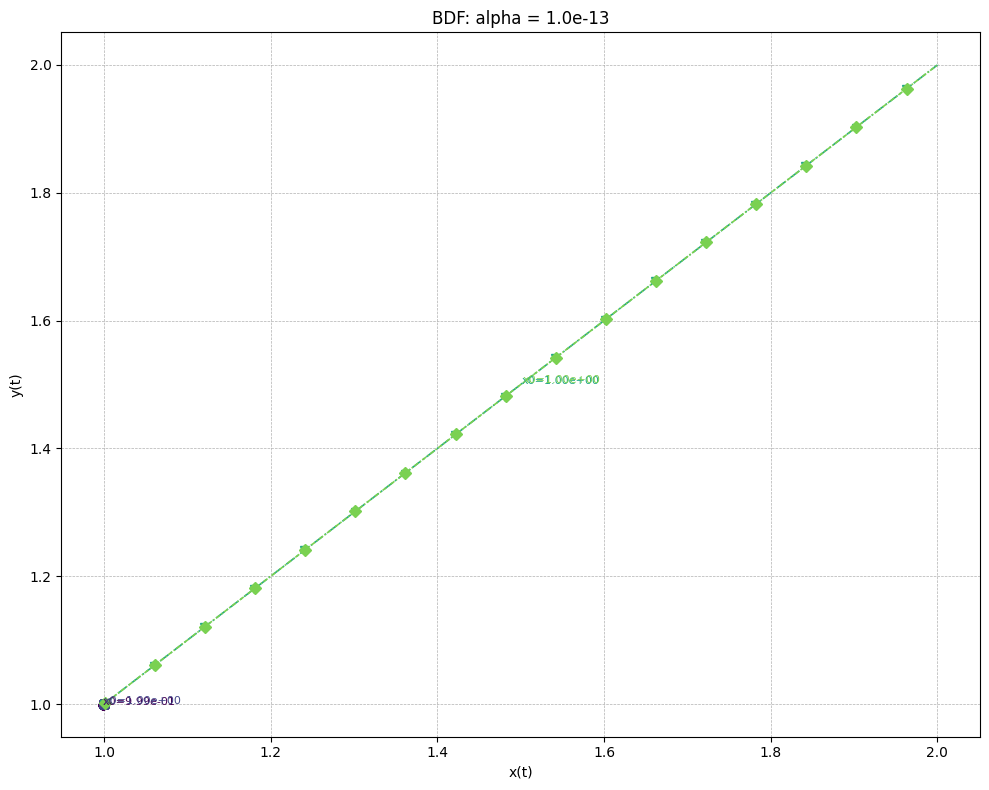

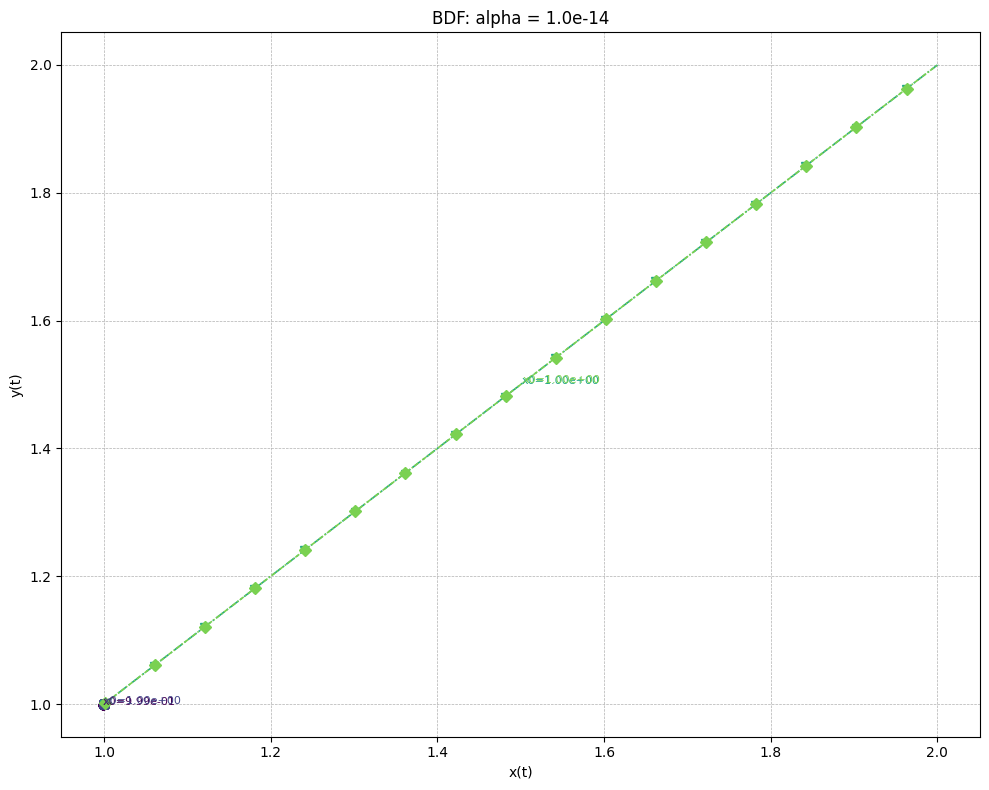

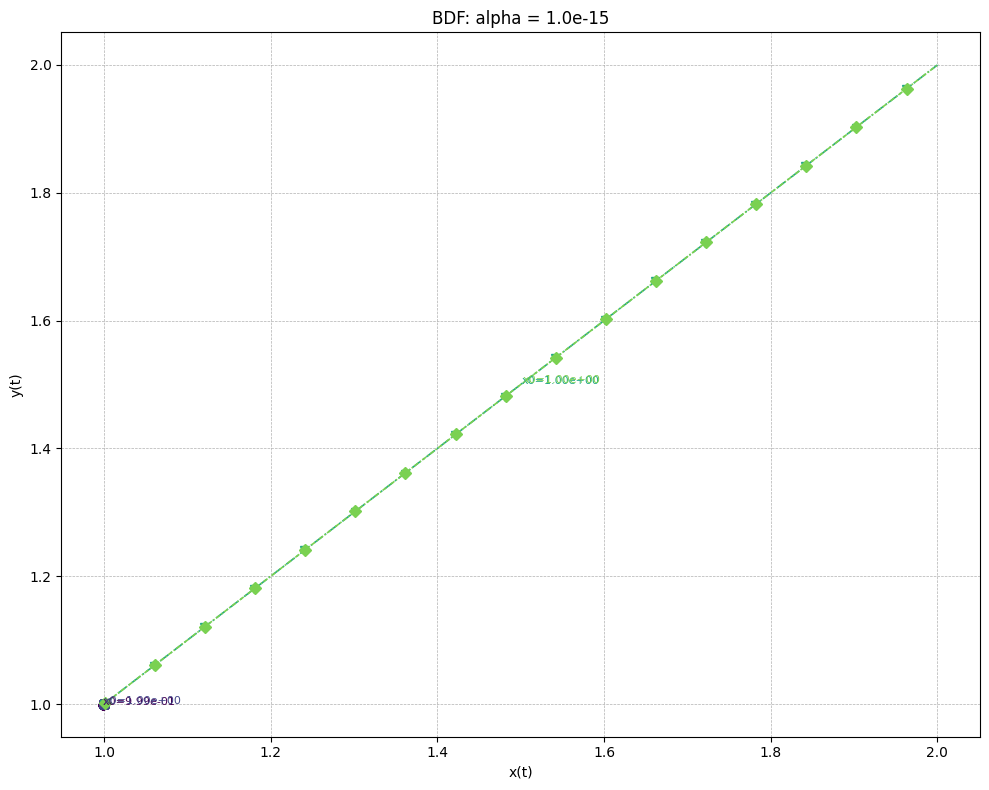

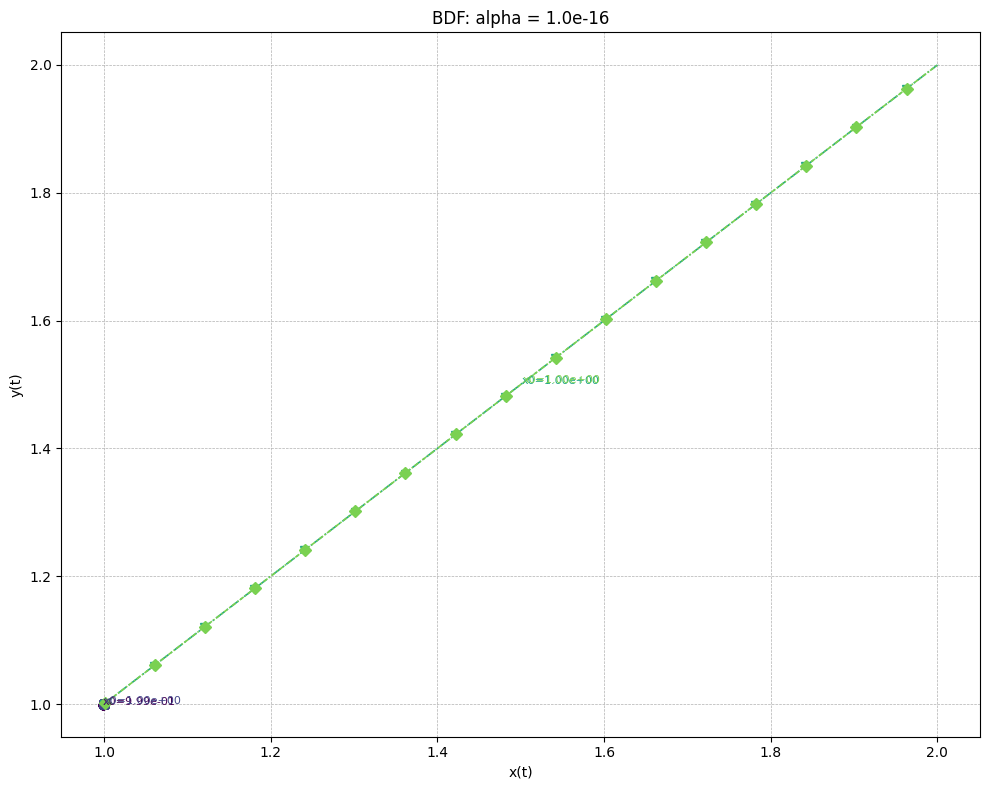

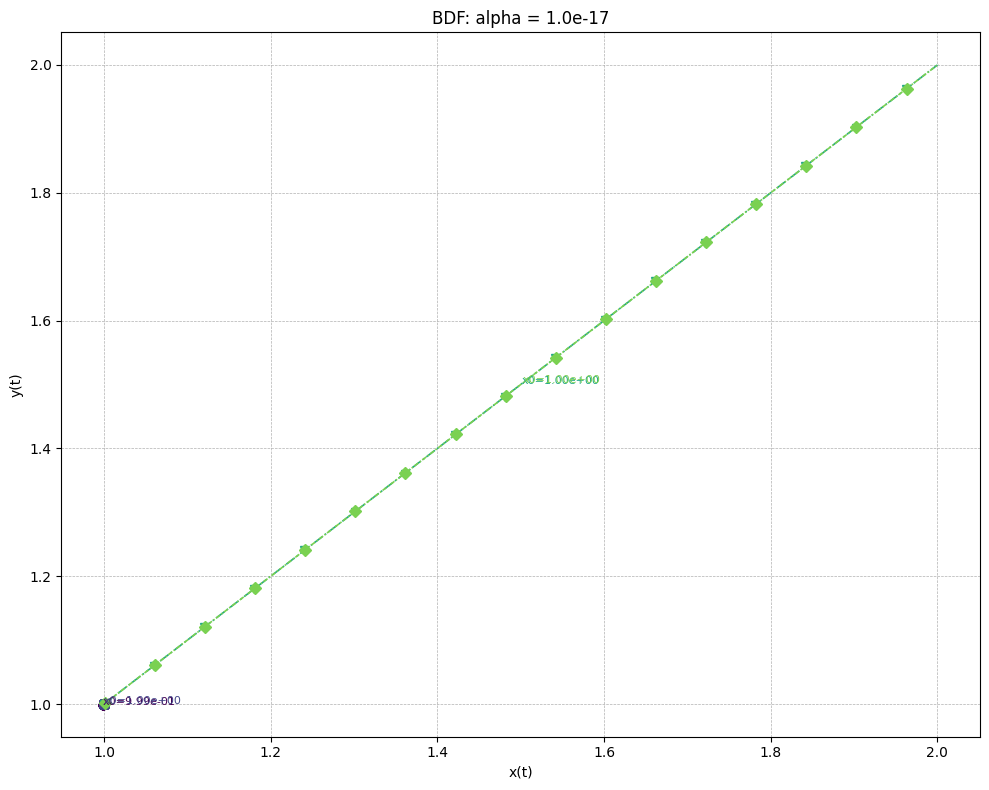

Solving with method: Radau


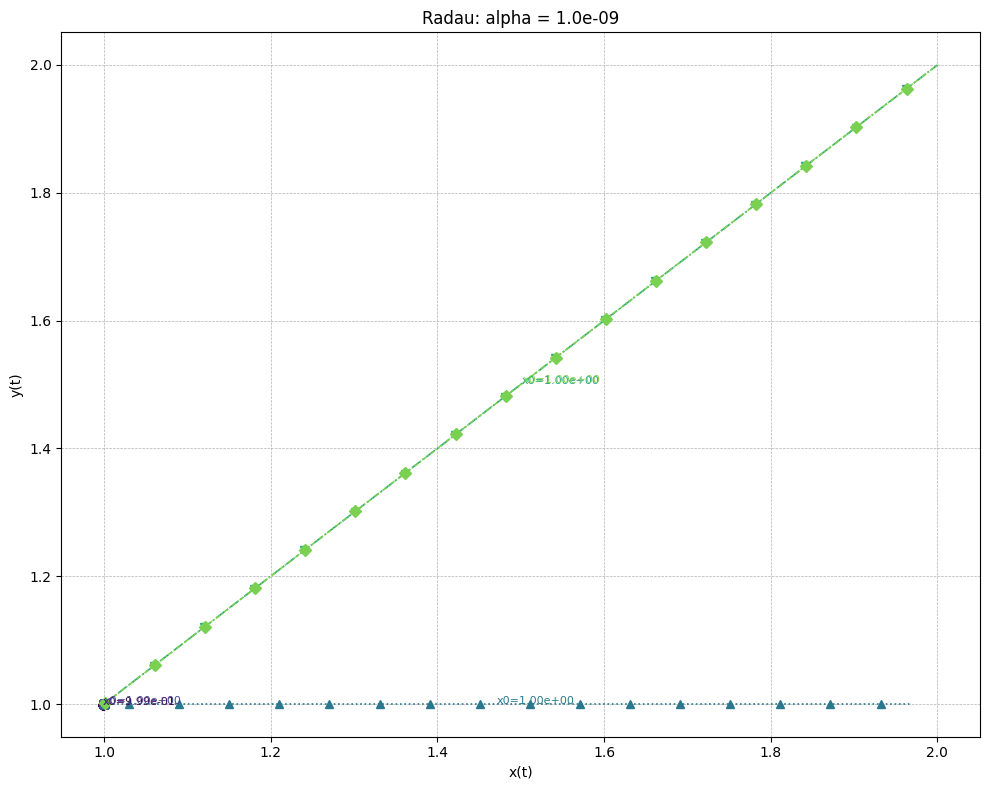

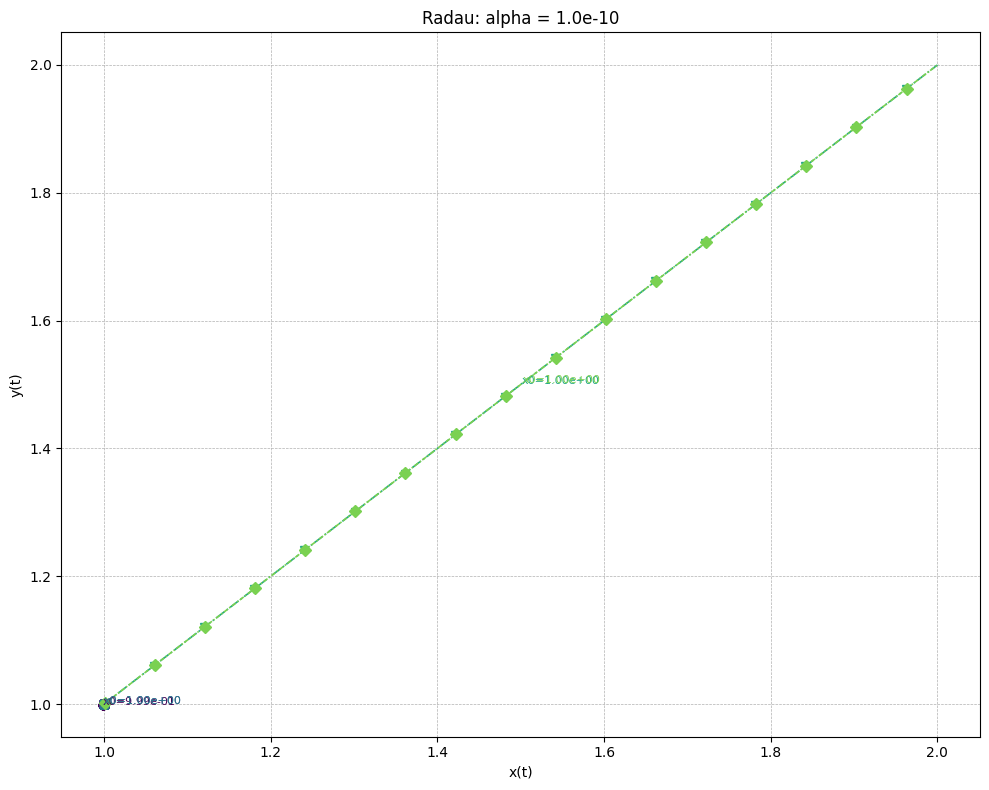

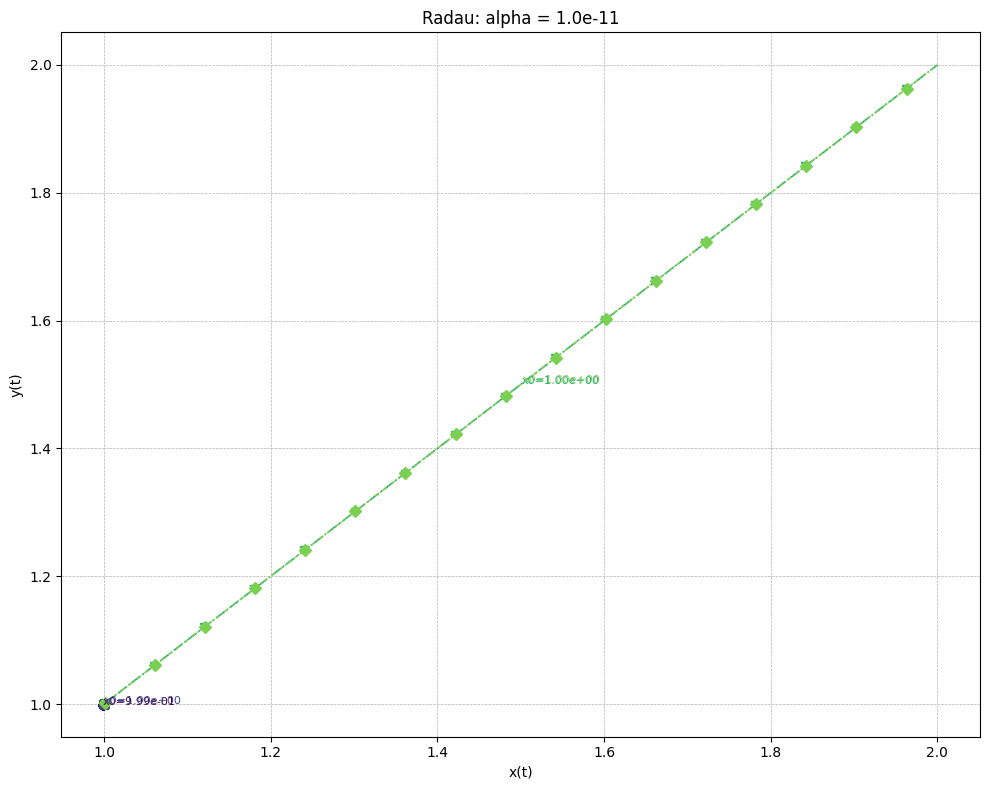

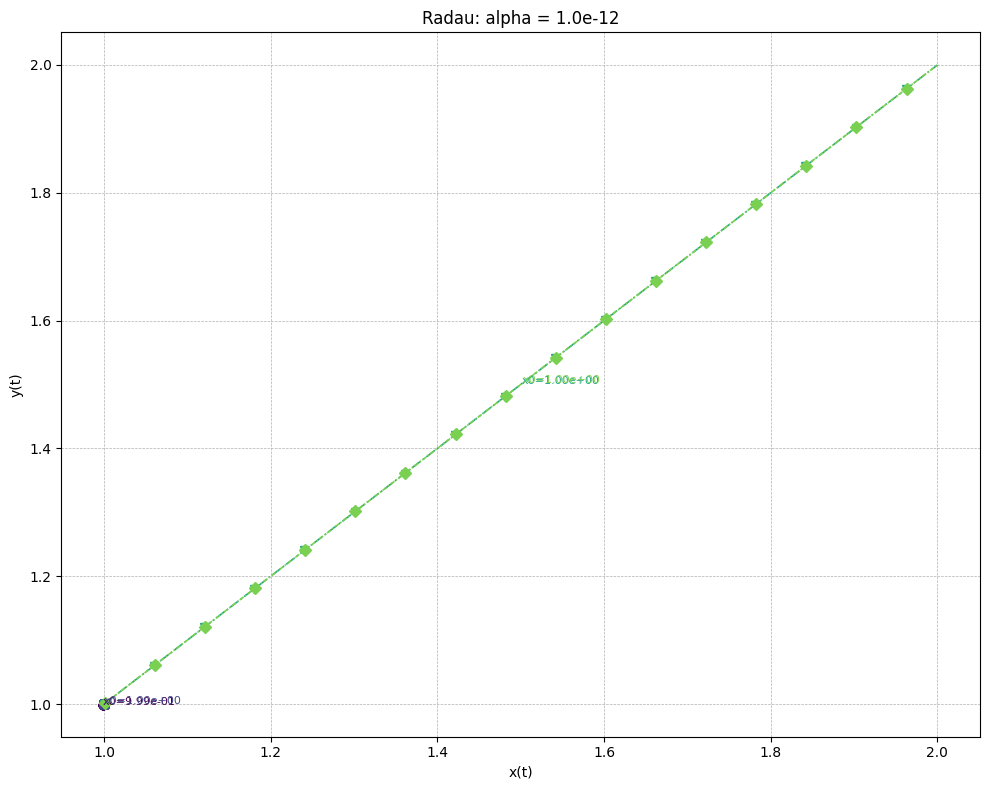

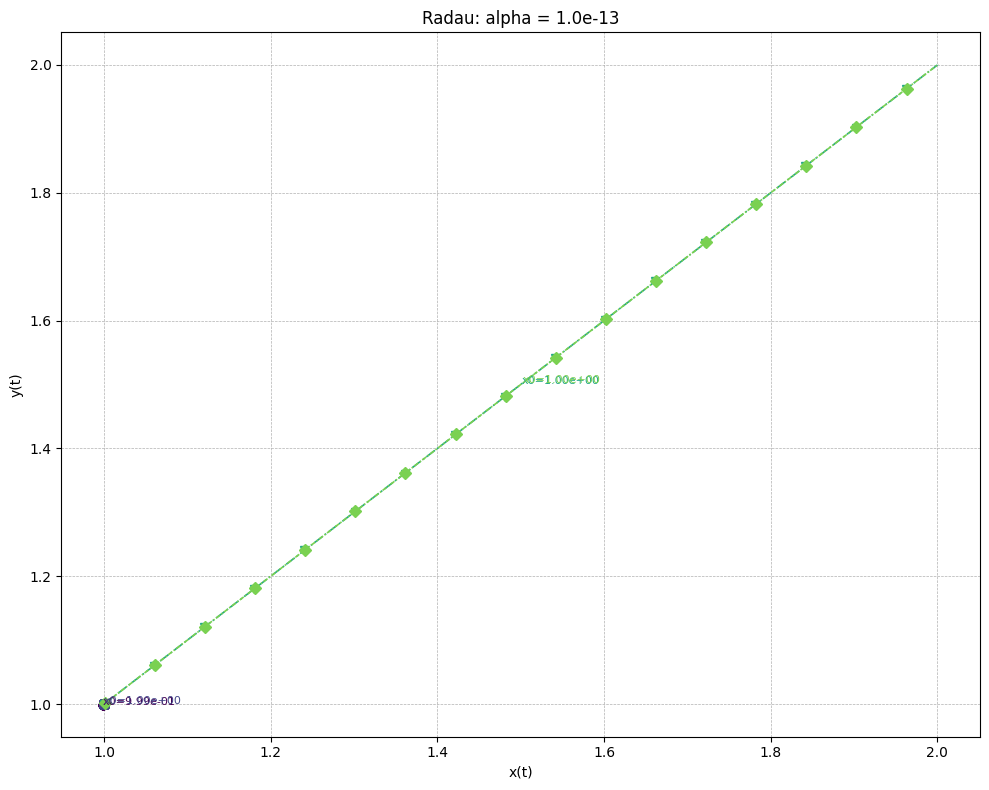

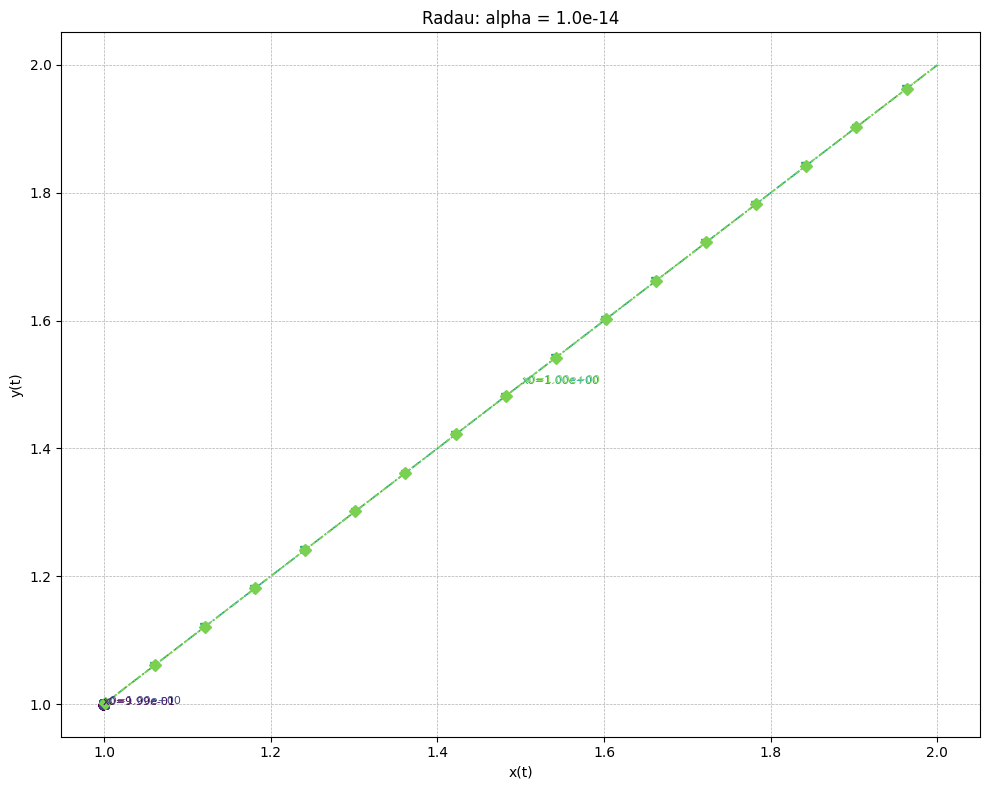

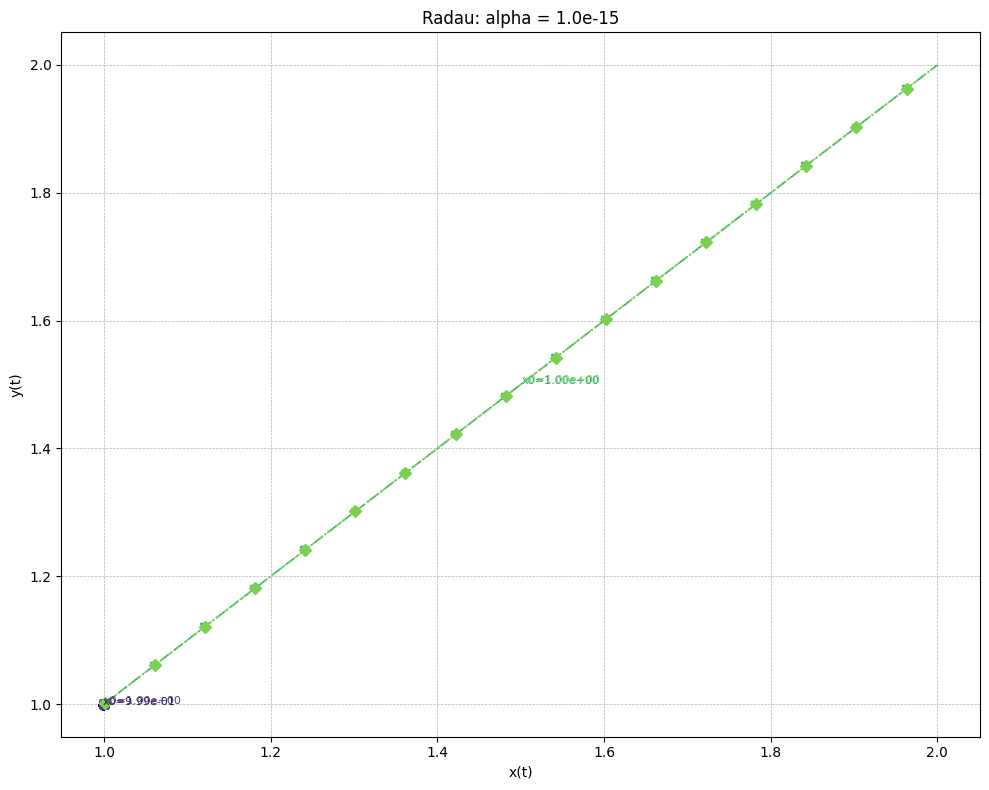

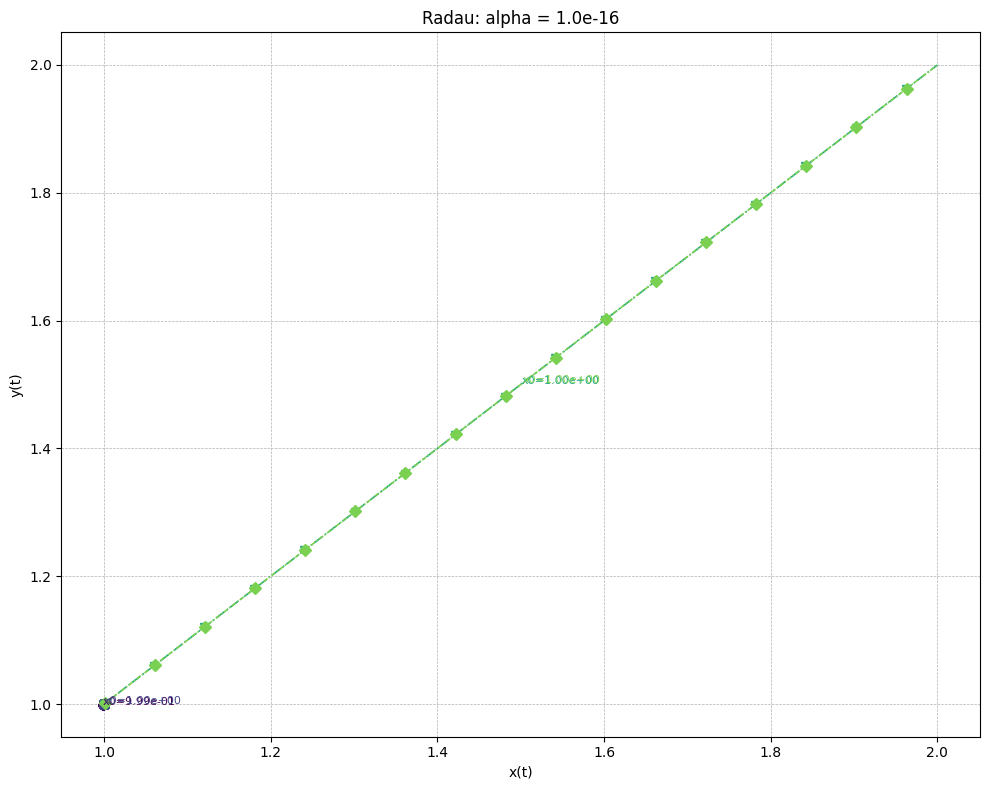

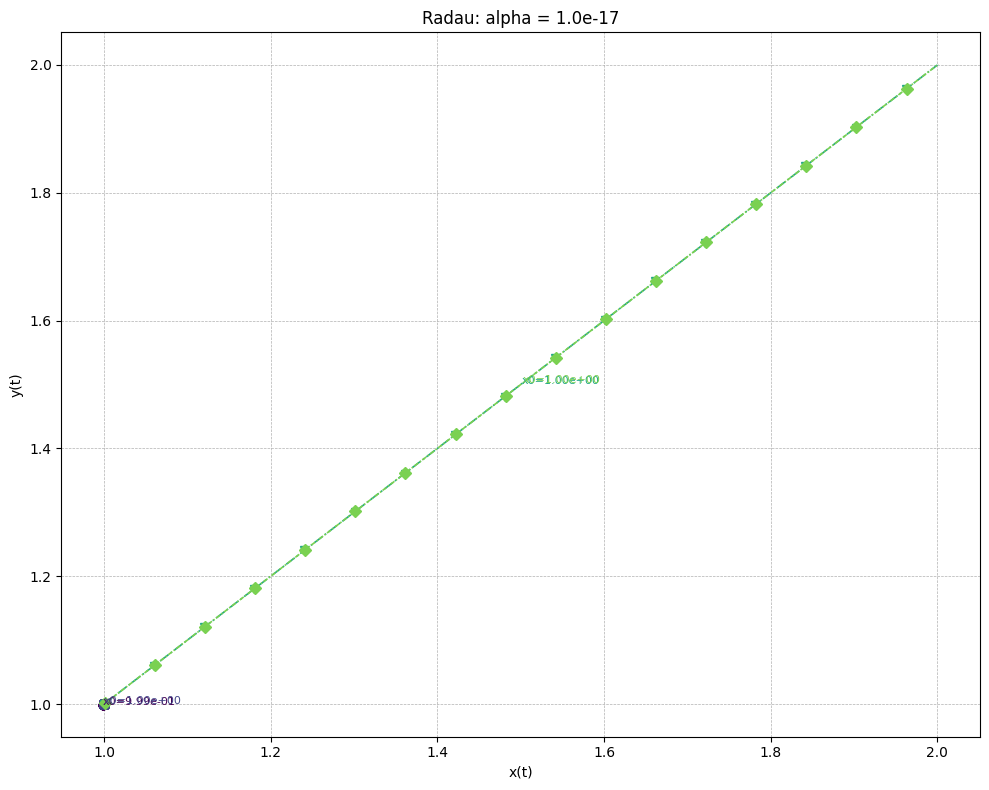

Solving with method: RK23


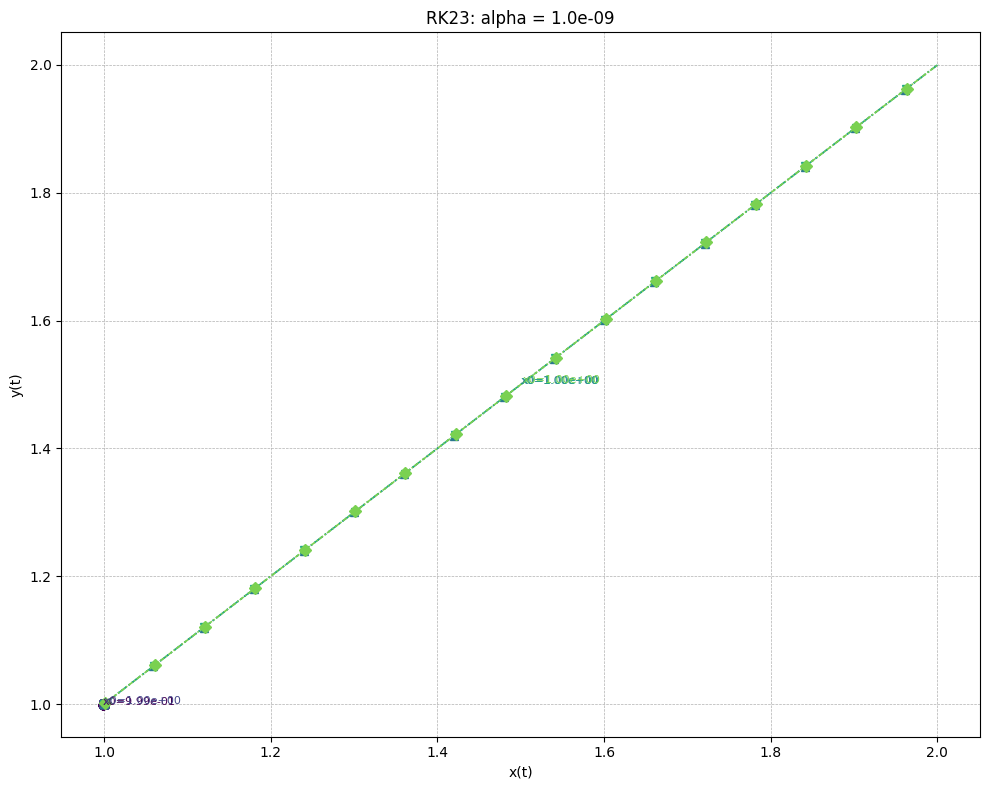

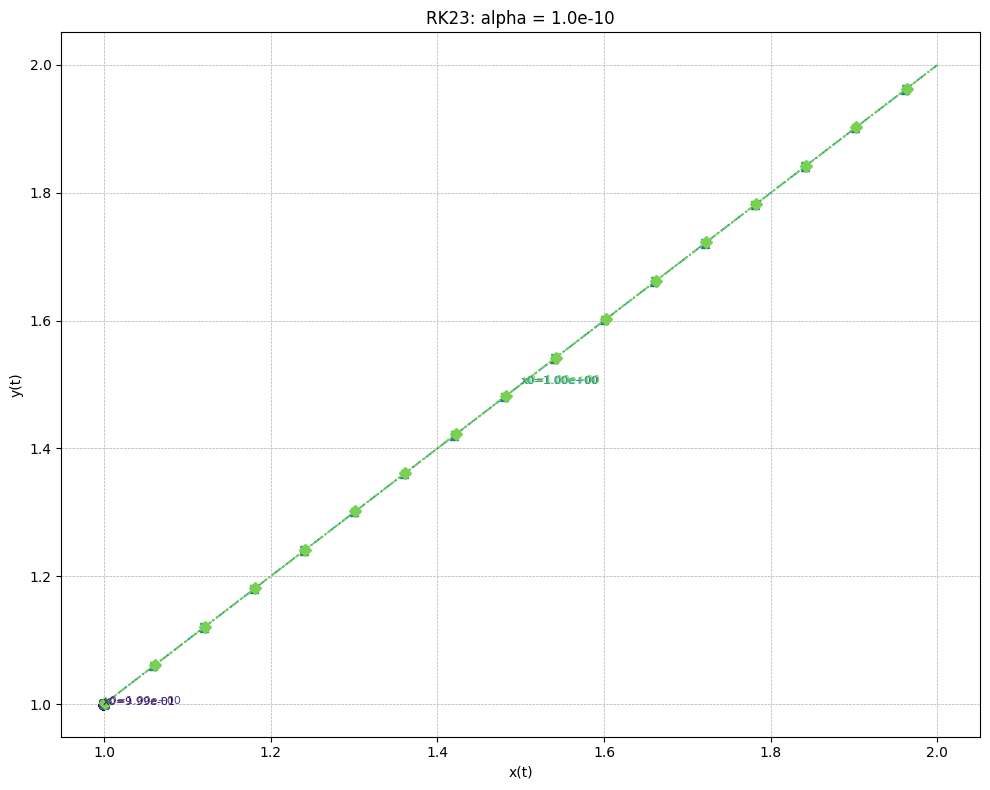

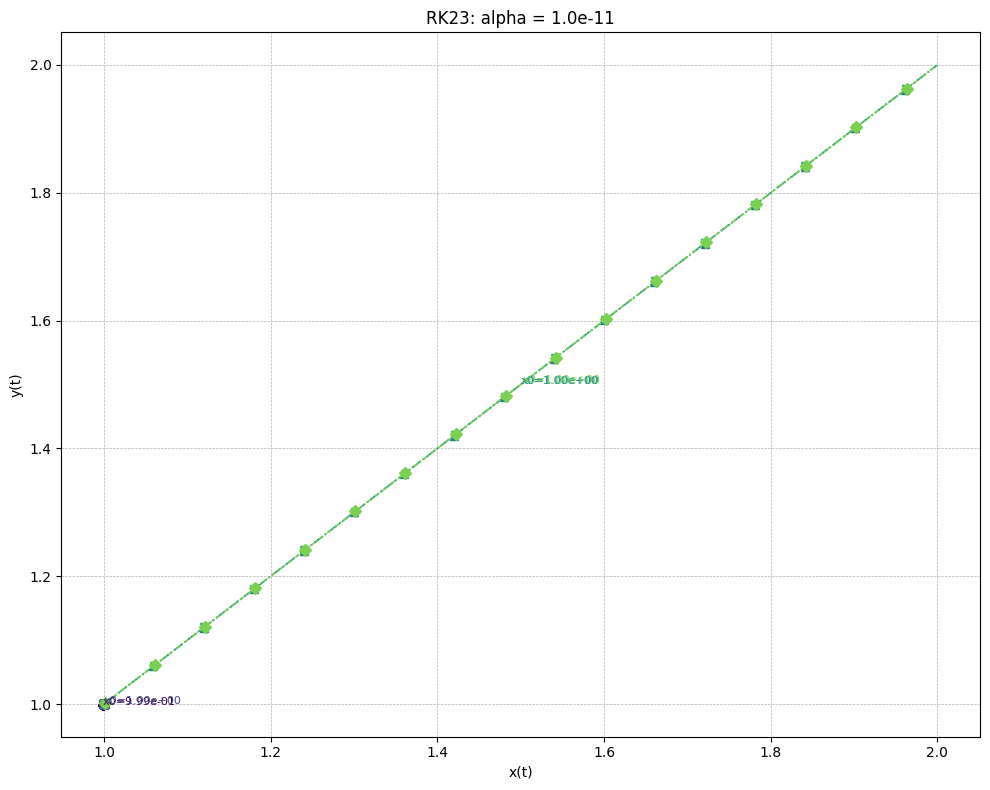

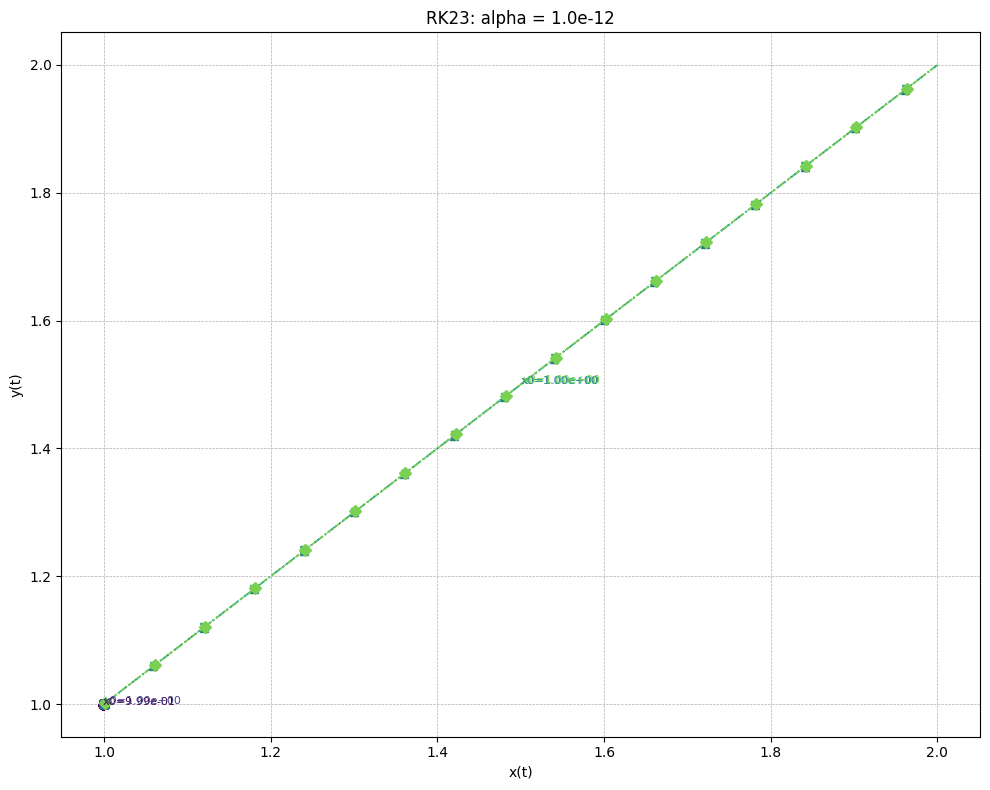

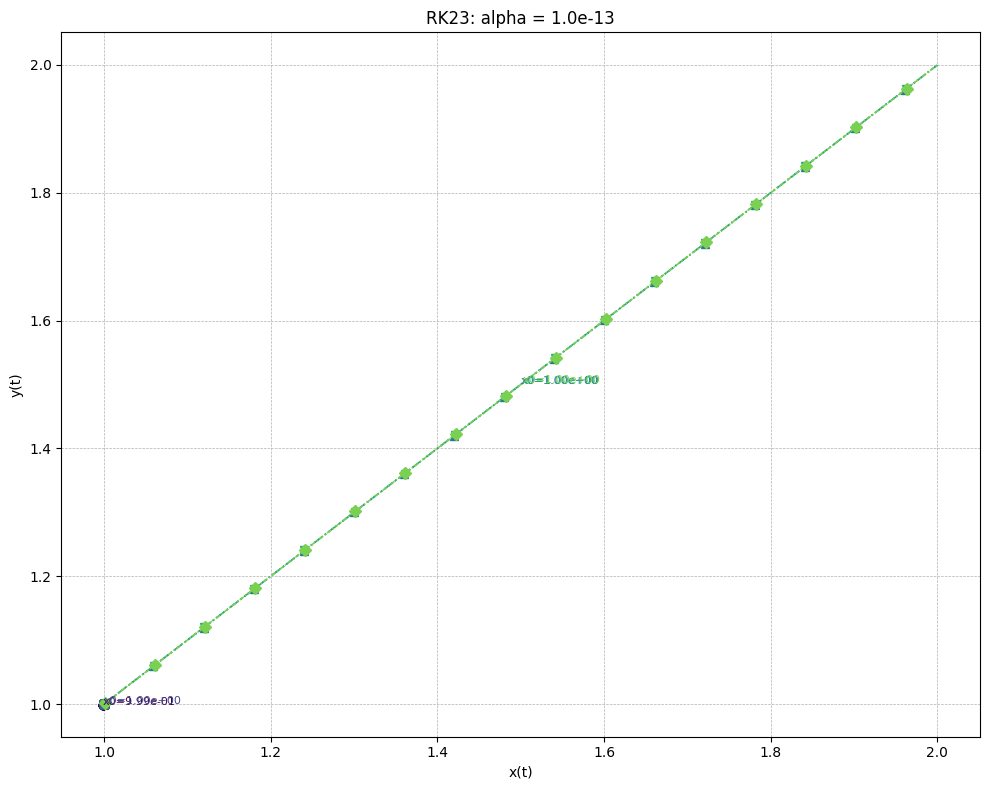

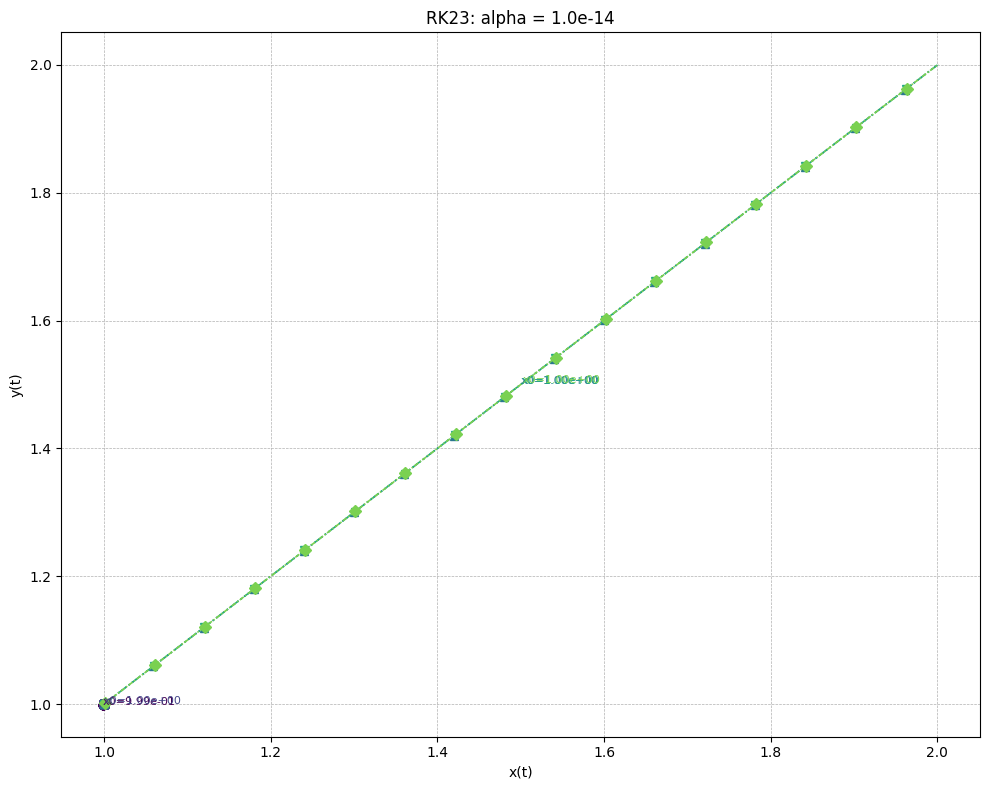

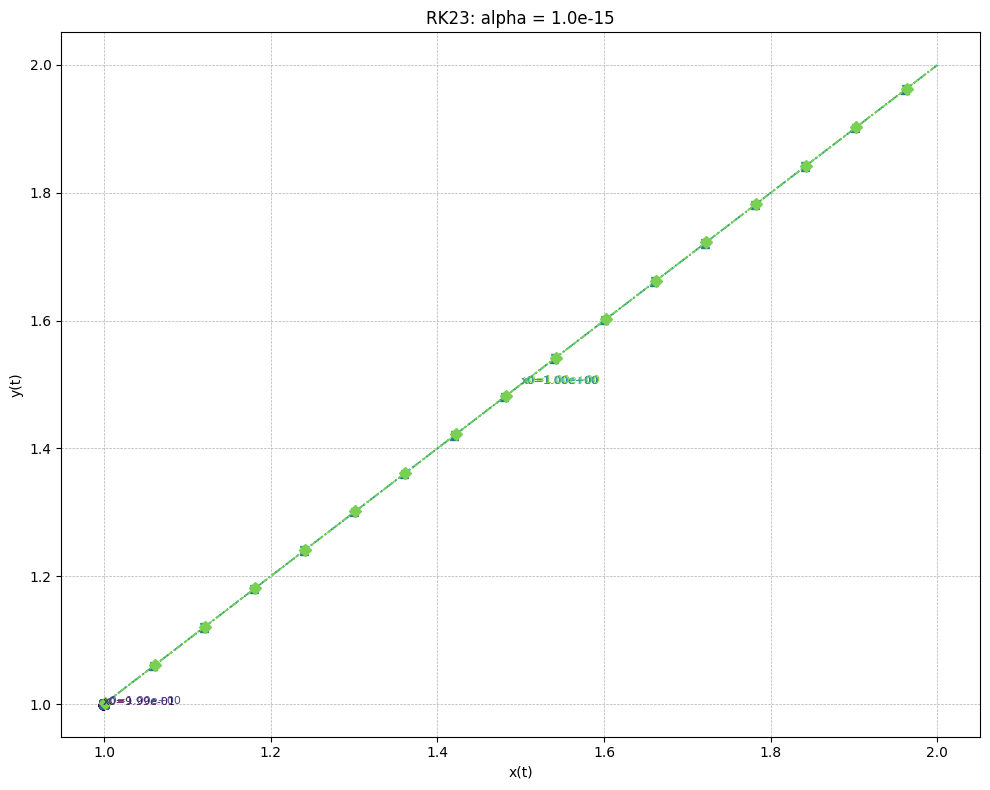

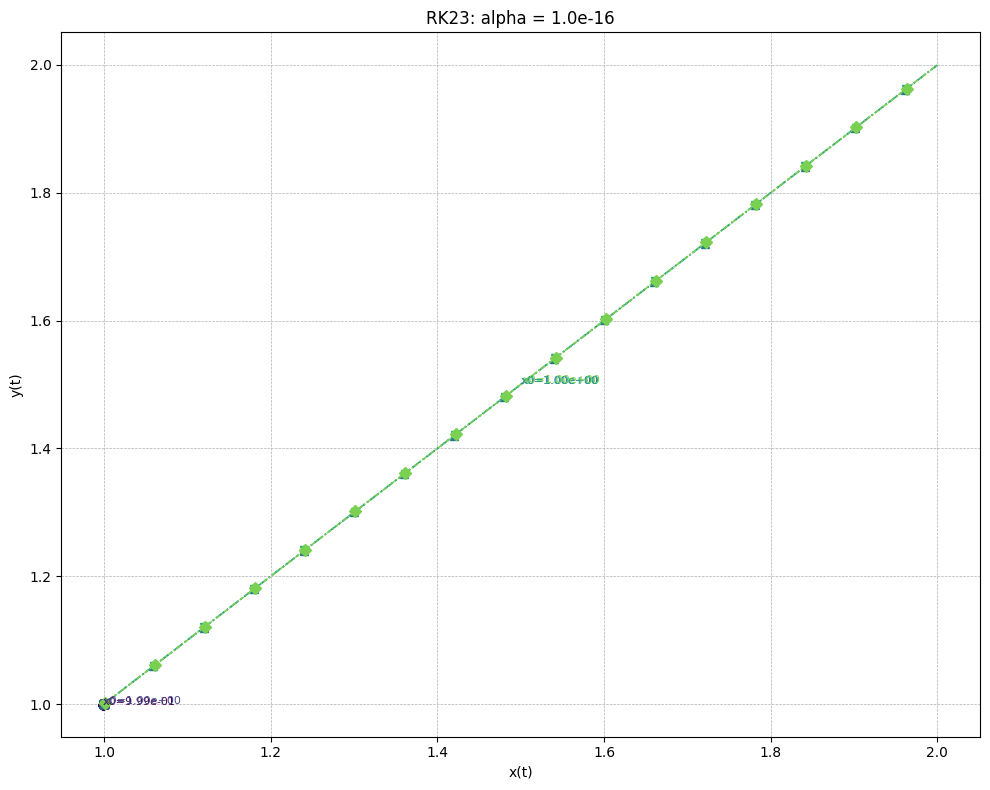

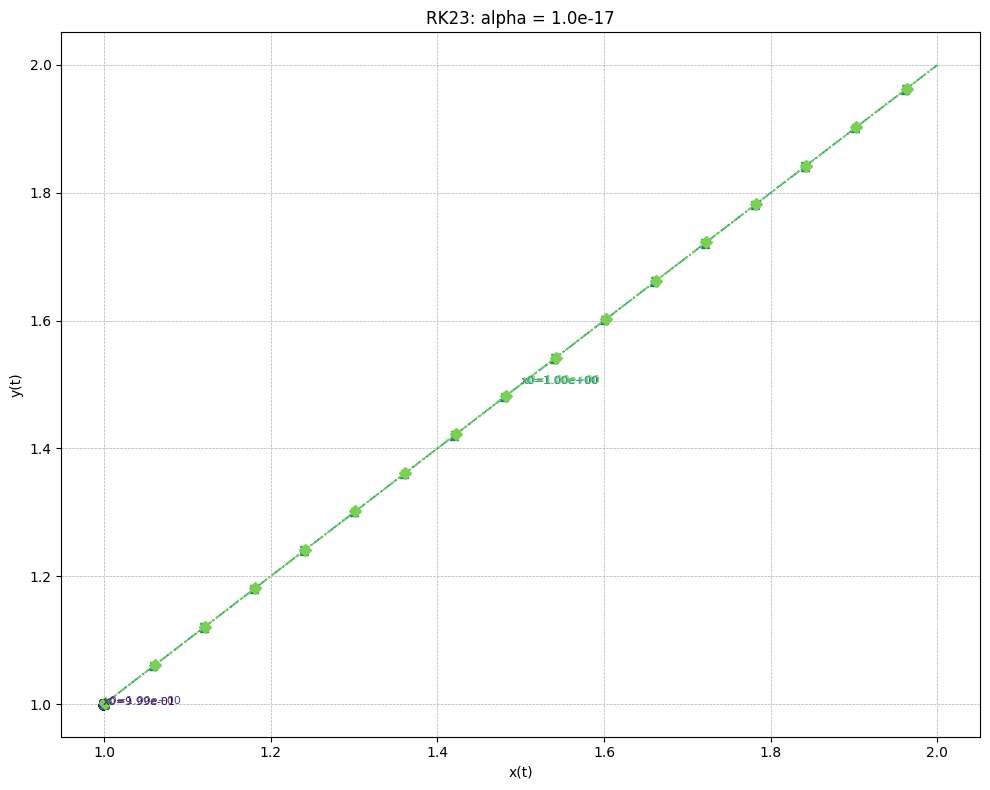

Solving with method: Symplectic


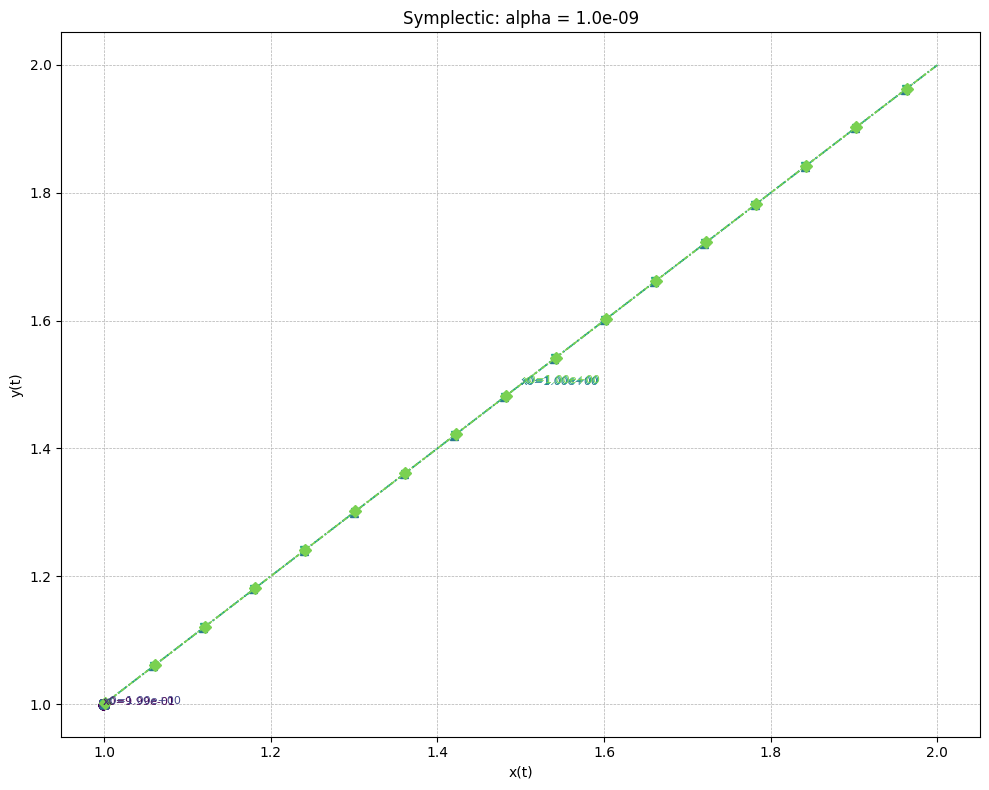

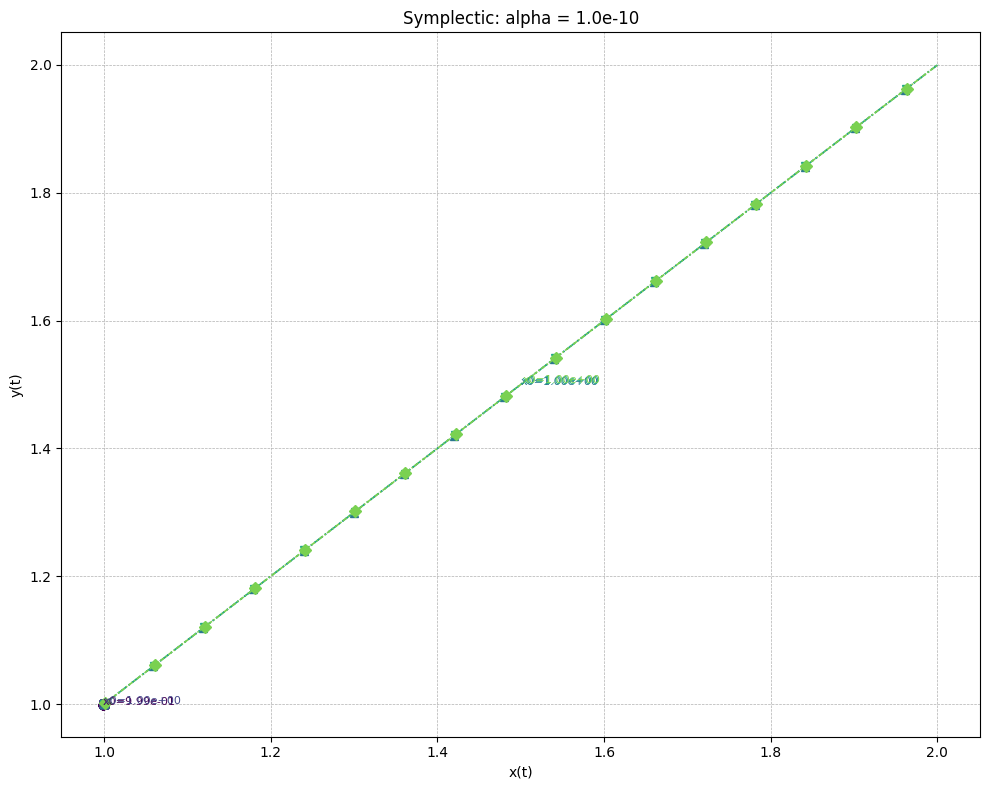

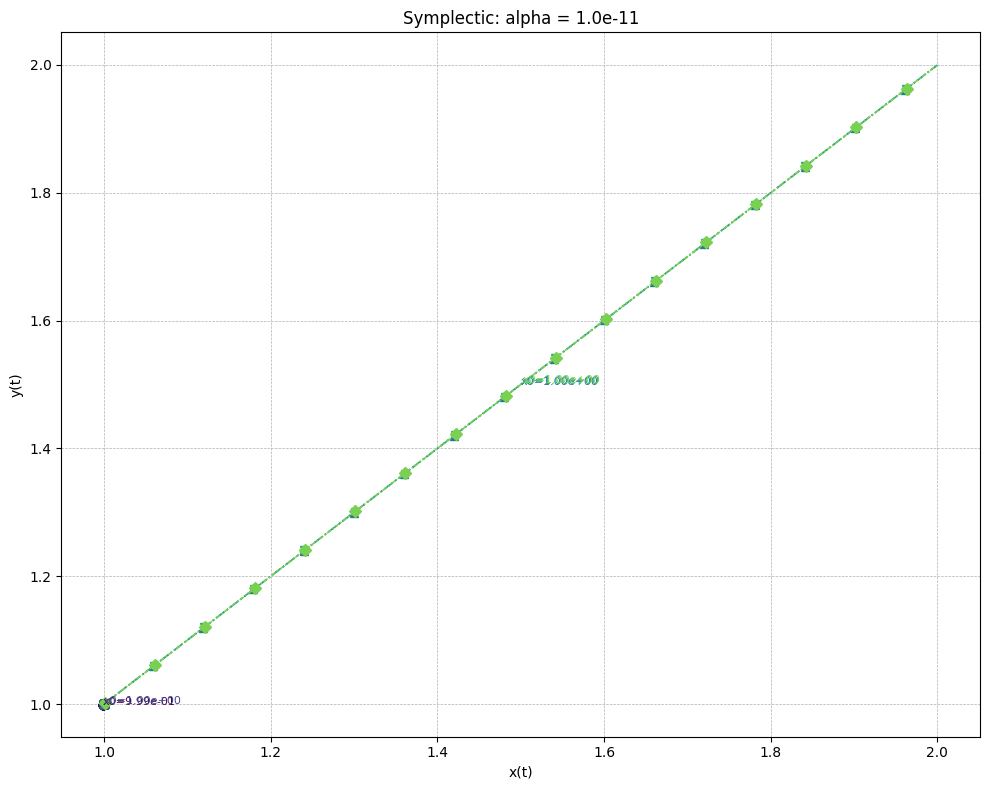

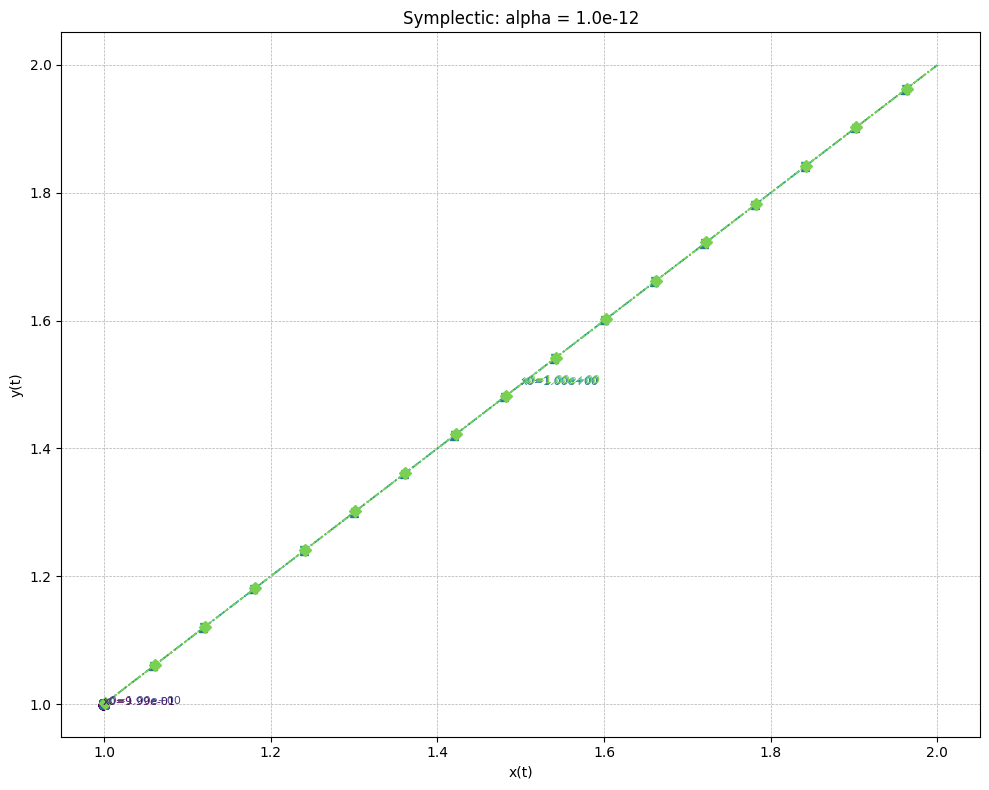

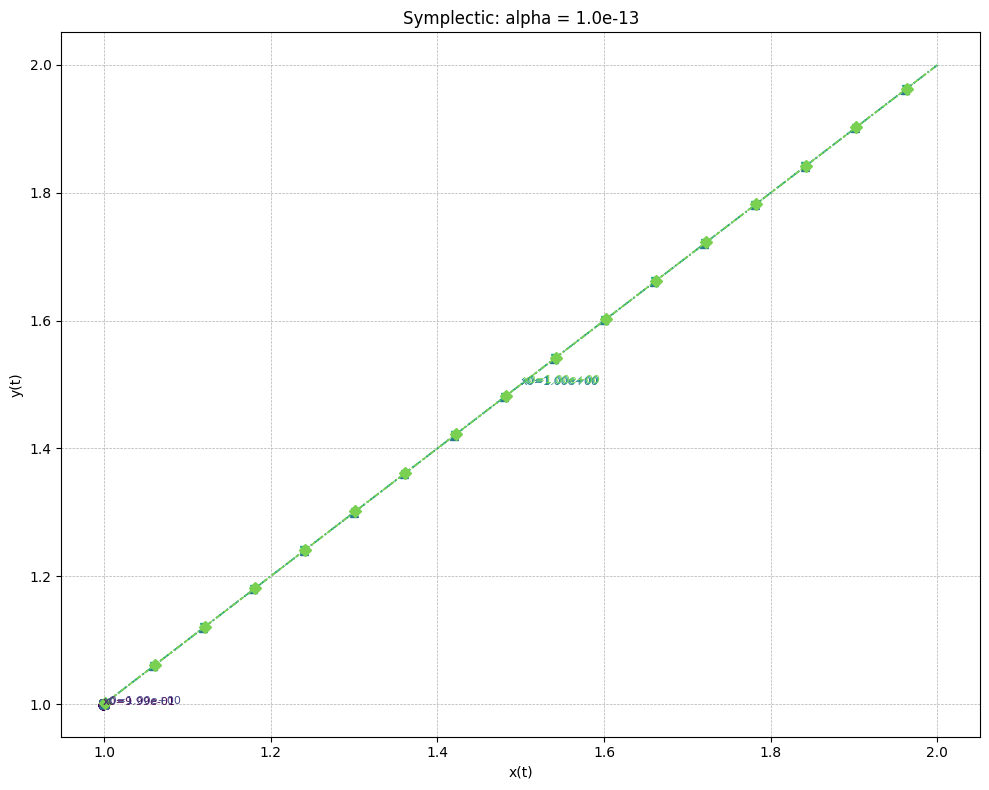

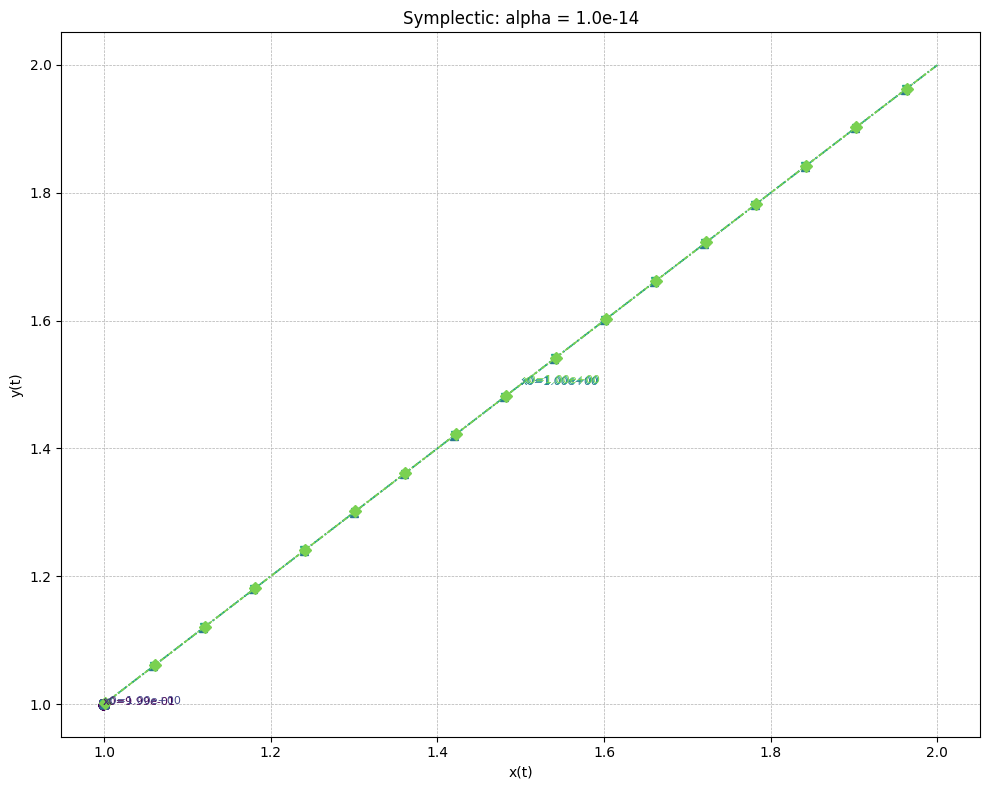

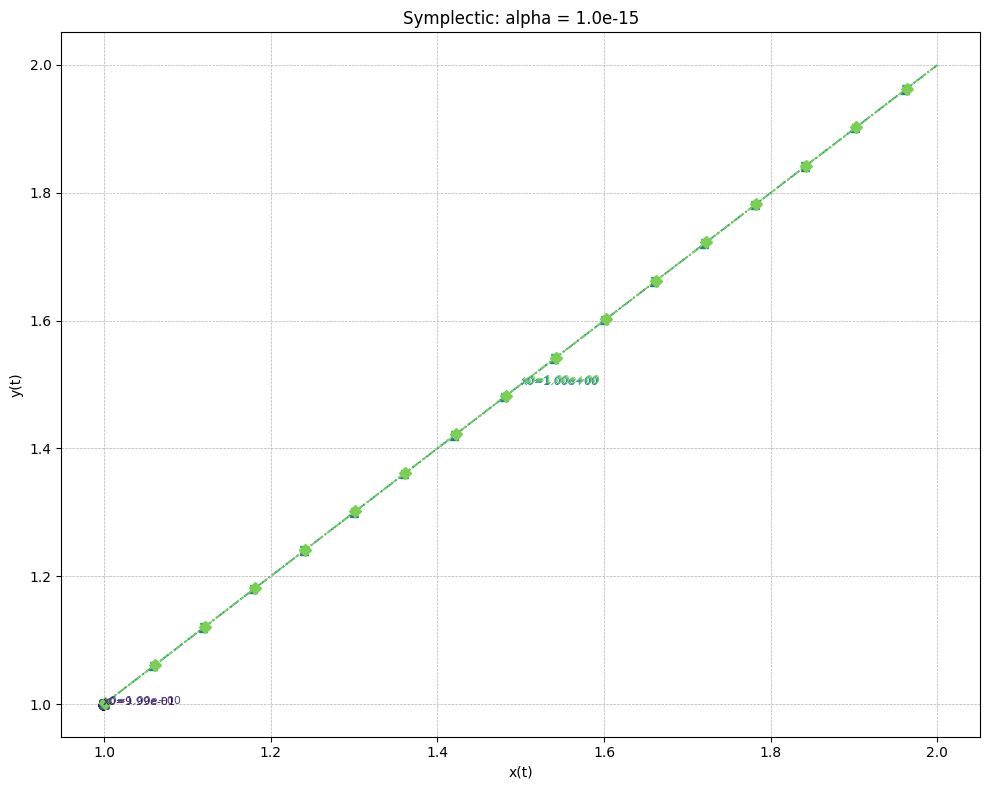

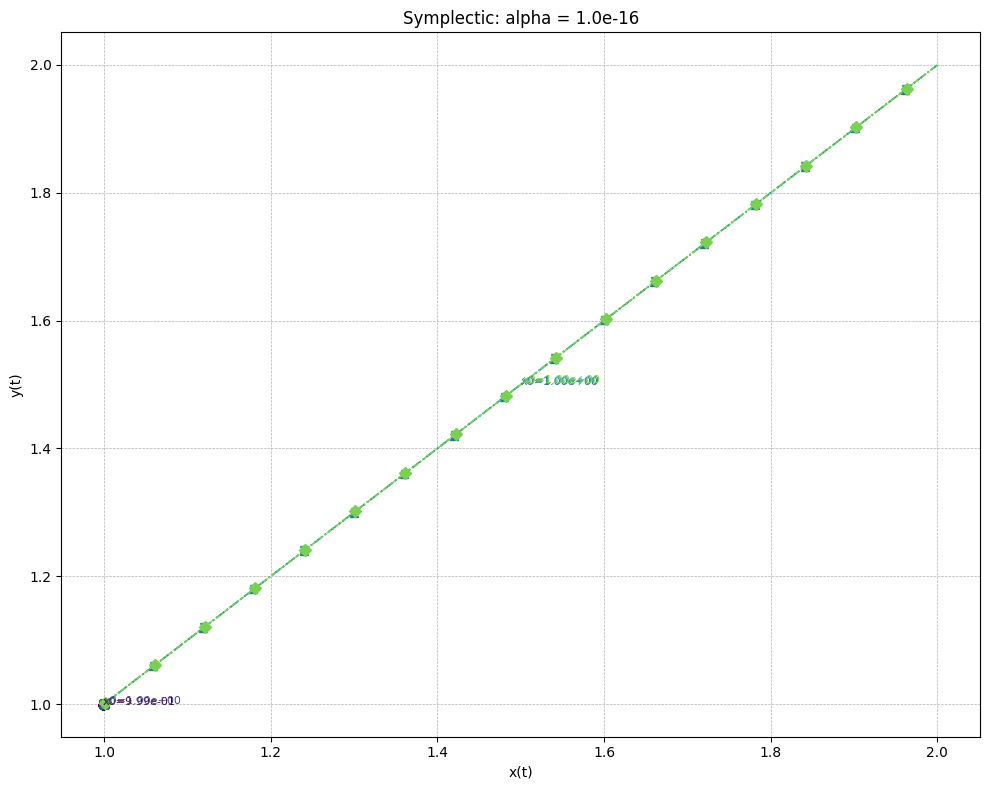

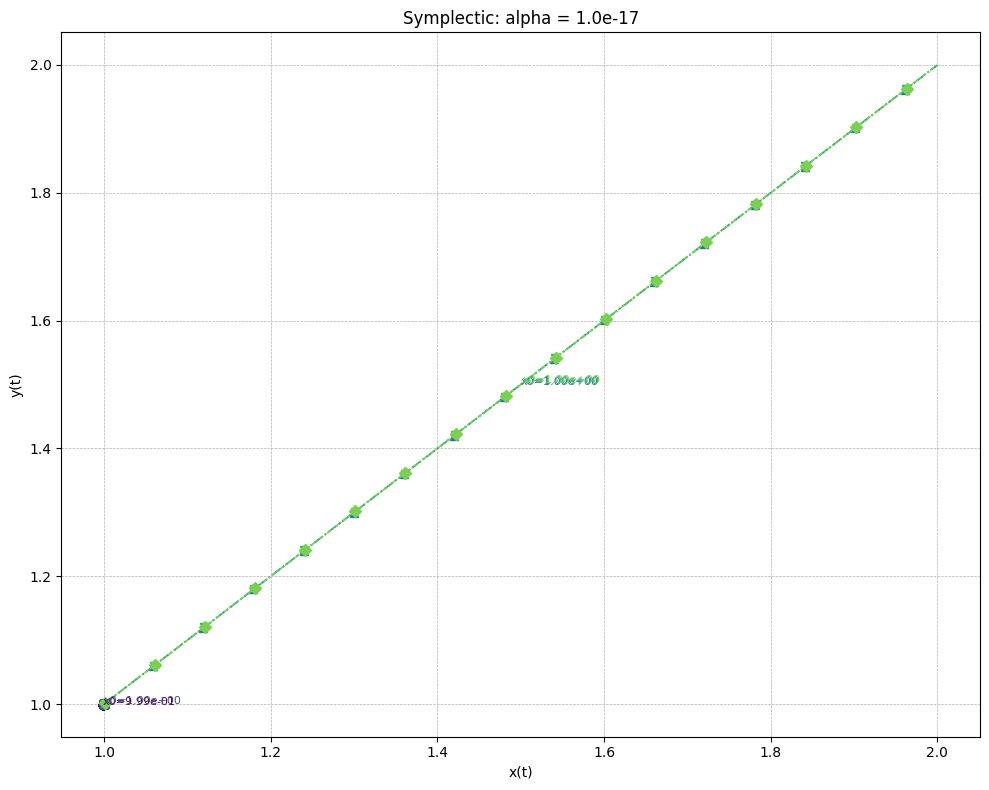

In [34]:
# Cell 3: Solve and plot per alpha and solver with varying initial conditions

for method in all_methods:
    print(f"Solving with method: {method}")
    for alpha in alpha_list:
        rhs = get_rhs_system(alpha, method, error_counts, K)
        plt.figure(figsize=(10, 8))
        failures = 0
        for shift in initial_shifts:
            x0 = b * (1 + shift)
            y0 = b * (1 + shift)
            try:
                if method == "Symplectic":
                    dt = t_eval[1] - t_eval[0]
                    x = [x0]
                    y = [y0]
                    for t_i in t_eval[:-1]:
                        rhs_val = rhs(t_i, [x[-1], y[-1]])
                        x.append(x[-1] + dt * rhs_val[0])
                        y.append(y[-1] + dt * rhs_val[1])
                    x_vals = np.array(x)
                    y_vals = np.array(y)
                else:
                    sol = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method=method)
                    x_vals = sol.y[0]
                    y_vals = sol.y[1]
                style = style_map[shift]
                plt.plot(x_vals, y_vals,
                         linestyle=style["linestyle"],
                         color=style["color"],
                         marker=style["marker"],
                         markevery=30,
                         linewidth=1.2)
                idx = len(x_vals) // 2
                plt.text(x_vals[idx], y_vals[idx], f"x0={x0:.2e}", fontsize=8, color=style["color"])
            except Exception as e:
                failures += 1
        if failures == len(initial_shifts):
            alpha_failed[method].append(alpha)
        plt.xlabel("x(t)")
        plt.ylabel("y(t)")
        plt.title(f"{method}: alpha = {alpha:.1e}")
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

/tmp/ipython-input-35-298464599.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


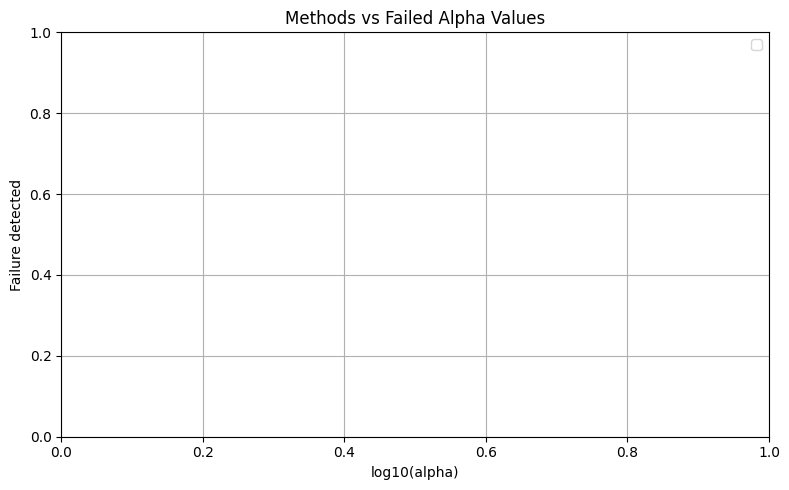

In [35]:
# Cell 4: Plot number of failures vs log10(alpha)

plt.figure(figsize=(8, 5))
for method in all_methods:
    alpha_vals = [np.log10(a) for a in alpha_failed[method]]
    errors = [1] * len(alpha_vals)
    if alpha_vals:
        plt.scatter(alpha_vals, errors, label=method)
plt.xlabel("log10(alpha)")
plt.ylabel("Failure detected")
plt.title("Methods vs Failed Alpha Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Cell 5: Lyapunov exponent estimation table
print("\n=== Lyapunov Exponents by alpha ===")
print("{:12s} | {:>10s}".format("alpha", "lambda"))
print("-" * 25)

for alpha in alpha_list:
    delta0 = 1e-9
    x0 = b * (1 - alpha * 10)
    y0 = b * (1 - alpha * 10)
    rhs = get_rhs_system(alpha, "Lyap", error_counts, K)
    try:
        sol1 = solve_ivp(rhs, [0, t_end], [x0, y0], t_eval=t_eval, method="RK45")
        sol2 = solve_ivp(rhs, [0, t_end], [x0 + delta0, y0], t_eval=t_eval, method="RK45")
        dists = np.linalg.norm(sol2.y.T - sol1.y.T, axis=1)
        log_d = np.log(np.clip(dists / delta0, 1e-12, 1e12))
        lyap_exp = (log_d[-1] - log_d[0]) / (t_eval[-1] - t_eval[0])
        print("{:12.1e} | {:10.4f}{}".format(alpha, lyap_exp, "  <---" if lyap_exp > 0.1 else ""))
    except Exception as e:
        print("{:12.1e} | FAILED".format(alpha))


=== Lyapunov Exponents by alpha ===
alpha        |     lambda
-------------------------
     1.0e-09 |    20.7042  <---
     1.0e-10 |    17.0907  <---
     1.0e-11 |    20.7042  <---
     1.0e-12 |    20.7042  <---
     1.0e-13 |    20.7042  <---
     1.0e-14 |    20.7042  <---
     1.0e-15 |    20.7042  <---
     1.0e-16 |    20.7042  <---
     1.0e-17 |    20.7042  <---


# 🧬📉 Анализ фазового пространства генрегуляторной системы — обновлённая версия

- **Цель**: Изучить фазовую динамику, бифуркации и чувствительность решений системы ОДУ, моделирующей генрегуляцию:  
  $$
  \frac{dx}{dt} = \frac{K \cdot x^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}, \quad
  \frac{dy}{dt} = \frac{K \cdot y^{1/\alpha}}{b^{1/\alpha} + x^{1/\alpha}}
  $$

- **Фиксированные параметры**:  
  - $b = 1.0$  
  - $K = 1.0$ (фиксированный скалярный множитель)  

- **Начальные условия**: Несколько точек около $b$:  
  $$
  x_0, y_0 \approx b \times (1 - \epsilon), \quad \epsilon \in \{10^{-7}, 10^{-8}, 10^{-9}\}
  $$  
  для исследования чувствительности и возможности нескольких траекторий решения.

- **Временной интервал**:  
  $$
  t \in [0, t_{\text{end}}], \quad t_{\text{end}} = 0.05
  $$

- **Диапазон альфа** (логарифмический масштаб, суженный):  
  $$
  \alpha \in \{10^{-9}, 10^{-10}, 10^{-11}, 10^{-12}, 10^{-13}, 10^{-14}\}
  $$

## ⚙️ Используемые численные решатели
- ⚡ `RK45` — явный метод Рунге-Кутты 4(5) с адаптивным шагом  
- 🌐 `DOP853` — высокопорядковый метод Dormand-Prince 8(5,3)  
- 🧱 `BDF` — метод обратных разностей, для жёстких систем  
- 🧿 `Radau` — A-устойчивый неявный метод Рунге-Кутты  
- 🐢 `RK23` — явный метод Рунге-Кутты 2(3), пониже порядок  
- 🌀 `Symplectic` — собственная реализация явного метода Эйлера (симплектический аналог)

## 📈 Визуализация и диагностика
- ✔️ Фазовые портреты ($y(t)$ против $x(t)$) для каждого решателя и каждого $\alpha$, на каждом графике показаны траектории для разных начальных условий.  
- ➡️ Стрелки (quiver) вдоль траекторий показывают направление потока — размер стрелок подобран для наглядности без засорения.  
- 🔄 Цвета, стили линий, маркеры используются для различения начальных условий; значения начальных условий подписаны прямо на кривых.  
- ⚠️ Учёт и логирование численных ошибок и сбоев для каждого решателя и $\alpha$.  
- 📊 Итоговая таблица по решателям с:  
  - Общим временем интегрирования  
  - Числом вычислений функции правой части (`nfev`), отражающим вычислительные затраты.

## 🧪 Расширенный численный анализ
- 🔍 **Оценка показателя Ляпунова**:  
  Приблизительный расчёт на основе расходимости близких траекторий.  
  Положительный показатель говорит о чувствительной зависимости и потенциальном хаосе.  
- 🌪️ **Обнаружение бифуркации Неймарк–Сакера**:  
  - Оценка отображения Пуанкаре (конечная точка решения)  
  - Якобиан, вычисленный численно по разностям начальных условий  
  - Анализ собственных чисел для выхода за единичную окружность (бифуркация).

## 📌 Примечания по реализации
- Начальные условия варьируются вблизи $b$ для проверки множественности решений и чувствительности.  
- Управление переполнением реализовано через ограничение экспонент в логарифмической области для предотвращения `NaN`/`Inf`.  
- Симплектический решатель — упрощённый явный метод Эйлера, поскольку в SciPy нет нативного симплектического метода.  
- Ошибки и неудачи интегрирования собираются и визуализируются в зависимости от $\alpha$, что помогает локализовать проблемные зоны параметра.

---

*Данный ноутбук даёт основу для исследования сложной динамики генрегуляторных ОДУ-систем, включая численную устойчивость, бифуркационный анализ и выявление хаоса с помощью множества решателей и перебора параметров.*